<img align="left" src = https://dirac.astro.washington.edu/wp-content/uploads/2022/03/DIRAC_logo-purple-text_transparent-bckg_ALPHA-1-1.png
 width=190 style="padding: 10px">
<br><b>Modeling White Dwarf Color-Magnitude Profiles with Gaia, SDSS and the Combined Montreal and Warwick White Dwarf Databases</b> <br>
Contact author: Bob Abel <br>
Last verified to run: 2023-06-05 <br>
LSST Science Piplines version: Weekly 2023_21 <br>
Container size: medium <br>
Targeted learning level: beginner? <br>
<figcaption align = "left"><b>&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;DiRAC Institute</b></figcaption>


**Objective:**<br>Model DA, DB and DC white dwarf color-magnitude profiles with SDSS photometry and Gaia photogeometric distances.<br>
**Methods:**<br> Data binning, curve-fitting.<br>
**Description:**<br> Color-magnitude models for DA, DB and DC white dwarfs are prepared using two publicly available white dwarf catalogs and Gaia and SDSS data<br>**Skills:**<br>Use ofMatplotlib, Pandas, and Astropy software, and the LSST pipeline dust model. Determination of the best model fit to data. <br>**LSST Data Products:**<br>Dustmaps. <br>**Credits:**<br>Tina Adair, Jennifer Soebeck, Douglas Tucker, Željko Ivezić, Brian Yanny, Allyn Smith, Allan Jackson, literally every single contributing author to the Rubin Stack Club, DP0 Tutorial, and Delegate Contribution Jupyter Notebooks, and Jake Vanderplas.



## <span style="color:blue">Table of Contents</span>
### <span style="color:blue">I. Introduction</span>
### <span style="color:blue">II. Load the combined White Dwarf data set.</span>
<span style="color:blue">From VizieR, we have [Gaia data with geometric and photogeometric distances](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/MNRAS/508/3877/maincat) at https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/MNRAS/508/3877/maincat. We have White Dwarfs from the [Montreal White Dwarf Database](https://www.montrealwhitedwarfdatabase.org/) and from the Warwick catalog (Fusillo et al. 2021).</span>
### <span style="color:blue">II. Analyze the Data Set</span>
<span style="color:blue">The data has been pre-filtered using CombineMontWarWDs.ipynb, but it what's left needs to be evaluated.</span>
### <span style="color:blue">III. Model White Dwarf DA, DB and DC colors</span>
<span style="color:blue">Bin SDSS colors vs. absolute magnitude and usse the median value. Evaluate the fits.</span>


### <span style="color:blue">I. Introduction</span>
<span style="color:blue">The largely hydrogen atmospheres and lack of fusion-related fluctuations make DA white dwarf stars good candidates as photometric distance candles. The Montreal White Dwarf Database contains thousands of objects with identified white dwarf subclasses, including the predominant DA variety. The Warwick database has fewer entries (still in the thousands), and a few are not in the Montreal database, so I've combined them. This database is merged with a Gaia DR3 database containing photogeometric and geometric distances, $T_{eff}$, log(g) and their SDSS magnitudes in each of the u, g, r, i and z filters. Our primary goal is to model the color-magnitude profile of DA, DB, and DC white dwarfs for the SDSS u-g, g-r, r-i and i-z colors (although I'm using the filter transmission values for the LSST filters).</span>

### <span style="color:blue">II. Get White Dwarfs</span>
<span style="color:blue"> After filtering, the Montreal White Dwarf Database had 5643, 658 and 378 DA, DB and DC candidates, respectively, while the white dwarf database described by Fusillo et al. 2021 and residing at Warwick University had 2255, 188, 116 DA, DB and DC candidates, respectively. Combining the catalogs and removing duplicates (in CombineMontWarWDs2.ipynb), resulted in 5870, 702 and 505 DA, DB and DC candidates, respectively, a 4.0%, 6.8% and 33.6% increase over the Montreal catalog for each class of white dwarfs.</span>

In [1]:
# import modules and make some labels

import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

# Import extinction maps
from dustmaps.sfd import SFDQuery

filter = ['u', 'g', 'r', 'i', 'z']
color = ['ug', 'gr', 'ri', 'iz']
color_label = ['u - g', 'g - r', 'r - i', 'i - z']


Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+f0a1800e64/config/.dustmapsrc


In [2]:
# Read in the white dwarf table.
df_GSMWWD = pd.read_csv('MontWarWDs.csv', low_memory=False)


In [3]:
print('Columns for pandas table df_GSMWWD and some sample data:')
df_GSMWWD.columns

Columns for pandas table df_GSMWWD and some sample data:


Index(['Unnamed: 0', 'level_0', 'index', 'GaiaEDR3', 'RA_ICRS', 'DE_ICRS',
       'Plx', 'Pwd', 'PM', 'pmRA', 'pmDE', 'Gmag', 'BPmag', 'RPmag', 'TeffH',
       'e_TeffH', 'loggH', 'e_loggH', 'MassH', 'TeffHe', 'e_TeffHe', 'loggHe',
       'e_loggHe', 'MassHe', 'Teffmix', 'e_Teffmix', 'loggmix', 'e_loggmix',
       'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'SDSS12',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'recno', 'spectype', 'l', 'b'],
      dtype='object')

In [4]:
df_GSMWWD.head()

,Unnamed: 0,level_0,index,GaiaEDR3,RA_ICRS,DE_ICRS,Plx,Pwd,PM,pmRA,...,SDSS12,umag,gmag,rmag,imag,zmag,recno,spectype,l,b
0,0,8,431,3222350478553854464,84.246336,0.370846,4.7258,0.996311,16.912,-8.269,...,J053659.12+002215.1,19.261999,18.841000,18.945000,19.100000,19.348000,120071,DA,203.861180,-16.326235
1,1,26,1273,286237751845802112,85.161994,62.375084,5.5243,0.996203,9.314,-0.610,...,J054038.87+622230.4,18.702000,18.554001,18.650000,18.822001,18.993999,121675,DC,150.315280,16.173937
2,2,56,4230,286977585732431488,88.307862,63.803054,12.6560,0.994720,102.149,-51.591,...,J055313.96+634812.0,18.448999,18.024000,17.941000,17.959000,18.020000,126996,DA,149.643799,18.085207
3,3,66,4970,558441062394445184,89.041275,83.965061,5.0625,0.998558,30.060,2.571,...,J055609.87+835754.4,18.514999,18.221001,18.504000,18.721001,19.004000,128133,DA,129.428658,25.537934
4,4,91,6461,1008228110854650880,90.633817,64.511052,9.2344,0.994186,70.104,12.972,...,J060232.09+643040.5,19.433001,18.913000,18.724001,18.660000,18.691000,130380,DA,149.394825,19.299017


### <span style="color:blue">V. Analyze the Data Set</span>


##### <span style="color:blue">Look at magnitudes, colors, position, log(g) and $T_{eff}$.</span>

(0.0, 700.0)

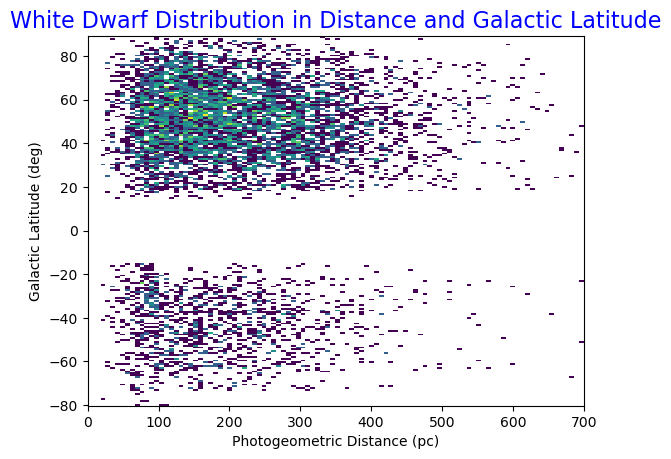

In [5]:
plt.hist2d(df_GSMWWD['rpgeo'], df_GSMWWD['b'], bins=(200,200), norm='log')
plt.xlabel('Photogeometric Distance (pc)')
plt.ylabel('Galactic Latitude (deg)')
plt.title('White Dwarf Distribution in Distance and Galactic Latitude', fontsize=16, color='blue')
plt.xlim(0, 700)
# plt.ylim(-25, 25)

#### <span style="color:blue">Correct the Rubin magnitudes for extinction (from [Jeff Carlin's contributed notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/MWhalo_density/Milky_Way_halo_density.ipynb))</span> 
##### <span style="color:blue">Look up the reddening values, E(B-V), from the maps of [Schlegel, Finkbeiner, & Davis (1998)](https://ui.adsabs.harvard.edu/abs/1998ApJ...500..525S/abstract) using the dustmaps package.  Convert them to per-band extinction values using the coefficients derived for DC2 in this [notebook by Sam Schmidt](https://github.com/LSSTDESC/DC2-analysis/blob/master/contributed/Derive_A_EBV_coefficients.ipynb) (see also this [demo](https://github.com/LSSTDESC/DC2-analysis/blob/master/contributed/DC2_object_deredden.ipynb) showing how to apply the corrections). The A_lambda/E(B-V) coefficients for the LSST u, g, r, u, z and y filters are 4.81, 3.64, 2.70, 2.06, 1.58 and 1.31, respectively. I should be using the SDSS values.</span>

In [6]:
# set the A_lamba/E(B-V) values for the six ugrizy LSST filters (what are the values for SDSS?)
# For LSST [u, g, r, i, z, y]: 
# band_a_ebv = np.array([4.81, 3.64, 2.70, 2.06, 1.58, 1.31])
# but for SDSS [u, g, r, i, z]:
band_a_ebv = [5.155, 3.793, 2.751, 2.086, 1.479]


In [7]:
coord = SkyCoord(ra=df_GSMWWD['RA_ICRS'], dec=df_GSMWWD['DE_ICRS'], unit='deg')

sfd = SFDQuery()
ebvvec = sfd(coord)
df_GSMWWD['ebv'] = ebvvec

In [8]:
df_GSMWWD['dered_u'] = df_GSMWWD['umag'] - df_GSMWWD['ebv']*band_a_ebv[0]
df_GSMWWD['dered_g'] = df_GSMWWD['gmag'] - df_GSMWWD['ebv']*band_a_ebv[1]
df_GSMWWD['dered_r'] = df_GSMWWD['rmag'] - df_GSMWWD['ebv']*band_a_ebv[2]
df_GSMWWD['dered_i'] = df_GSMWWD['imag'] - df_GSMWWD['ebv']*band_a_ebv[3]
df_GSMWWD['dered_z'] = df_GSMWWD['zmag'] - df_GSMWWD['ebv']*band_a_ebv[4]


In [9]:
# Calculate some colors
df_GSMWWD['ug'] = df_GSMWWD['dered_u'] - df_GSMWWD['dered_g']
df_GSMWWD['gr'] = df_GSMWWD['dered_g'] - df_GSMWWD['dered_r']
df_GSMWWD['ri'] = df_GSMWWD['dered_r'] - df_GSMWWD['dered_i']
df_GSMWWD['iz'] = df_GSMWWD['dered_i'] - df_GSMWWD['dered_z']
df_GSMWWD['gi'] = df_GSMWWD['dered_g'] - df_GSMWWD['dered_i']
df_GSMWWD['rz'] = df_GSMWWD['dered_r'] - df_GSMWWD['dered_z']


####  <span style="color:blue">Calculate absolute magnitudes: M = m - 5*$log_{10}$(d) + 5 </span>

In [10]:
# Calculate absolute magnitudes: M = m - 5*log10(d) + 5
df_GSMWWD['u_MagAbs'] = df_GSMWWD['dered_u'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['g_MagAbs'] = df_GSMWWD['dered_g'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['r_MagAbs'] = df_GSMWWD['dered_r'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['i_MagAbs'] = df_GSMWWD['dered_i'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['z_MagAbs'] = df_GSMWWD['dered_z'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5

print('Range of (unextincted) absolute magnitudes: ')
print('%2.2f < Abs u Mag < %2.2f' %(np.min(df_GSMWWD['u_MagAbs']), np.max(df_GSMWWD['u_MagAbs'])))
print('%2.2f < Abs g Mag < %2.2f' %(np.min(df_GSMWWD['g_MagAbs']), np.max(df_GSMWWD['g_MagAbs'])))
print('%2.2f < Abs r Mag < %2.2f' %(np.min(df_GSMWWD['r_MagAbs']), np.max(df_GSMWWD['r_MagAbs'])))
print('%2.2f < Abs i Mag < %2.2f' %(np.min(df_GSMWWD['i_MagAbs']), np.max(df_GSMWWD['i_MagAbs'])))
print('%2.2f < Abs z Mag < %2.2f' %(np.min(df_GSMWWD['z_MagAbs']), np.max(df_GSMWWD['z_MagAbs'])))
print(' ')


Range of (unextincted) absolute magnitudes: 
4.52 < Abs u Mag < 16.97
6.09 < Abs g Mag < 15.77
7.64 < Abs r Mag < 15.29
8.08 < Abs i Mag < 15.51
8.36 < Abs z Mag < 16.11
 


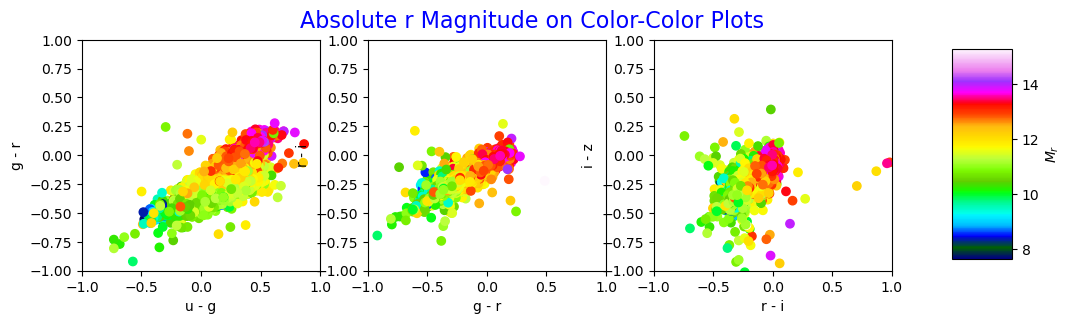

In [11]:
# These color-color plots markers are colored by absolute r magnitude.

cmap = colormaps['gist_ncar']
fig, ax = plt.subplots(1, 3, figsize=(12,3))
for i in range(3):
    im = ax[i].scatter(df_GSMWWD[color[i]], df_GSMWWD[color[i+1]], c=df_GSMWWD["r_MagAbs"], 
                       cmap=cmap)
    ax[i].set_xlabel(filter[i] + ' - ' + filter[i+1])
    ax[i].set_ylabel(filter[i+1] + ' - ' + filter[i+2])
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-1, 1)
 
fig.suptitle('Absolute r Magnitude on Color-Color Plots', fontsize=16, color='blue')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='$M_{r}$')

Text(0.5, 1.0, 'H-R Diagram for White Dwarfs')

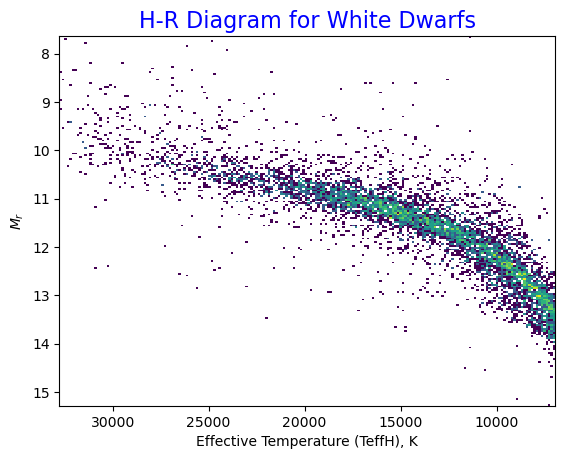

In [12]:
plt.hist2d(df_GSMWWD['TeffH'], df_GSMWWD['r_MagAbs'], bins=(200,200), norm='log')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature (TeffH), K')
plt.ylabel('$M_{r}$')
plt.title('H-R Diagram for White Dwarfs', fontsize=16, color='blue')

#### <span style='color:blue'> The WD region above matches the H-R Diagram parameters.</span>

#### <span style='color:blue'> Plot the reduced proper motion, H.</span>

Text(0.5, 1.0, 'Reduced Proper Motioin for White Dwarf Candidates 16 <= $m_{r}$<=18')

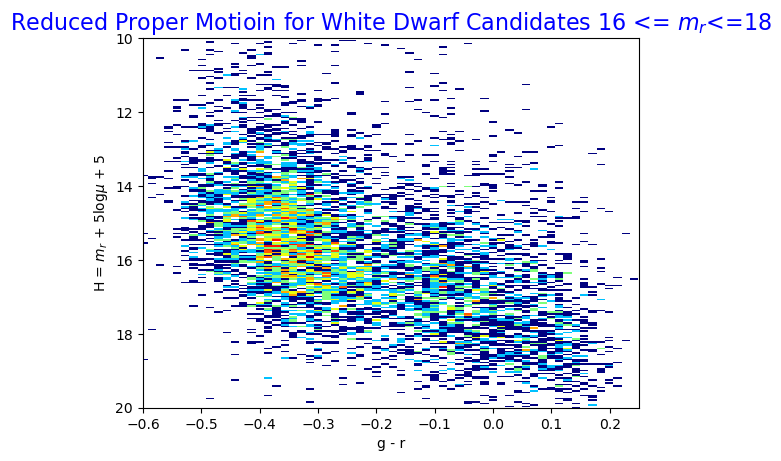

In [13]:
df_GSMWWD['H'] = df_GSMWWD['dered_r'] + 5 * np.log10(df_GSMWWD['PM']/1000.) + 5

plt.hist2d(df_GSMWWD['gr'], df_GSMWWD['H'], bins=(400, 400), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
plt.xlim(-.6, .25)
plt.ylim(10, 20)
plt.gca().invert_yaxis()
plt.xlabel('g - r')
plt.ylabel('H = $m_{r}$ + 5log$\mu$ + 5')
plt.title('Reduced Proper Motioin for White Dwarf Candidates 16 <= $m_{r}$<=18', fontsize=16, color='blue')


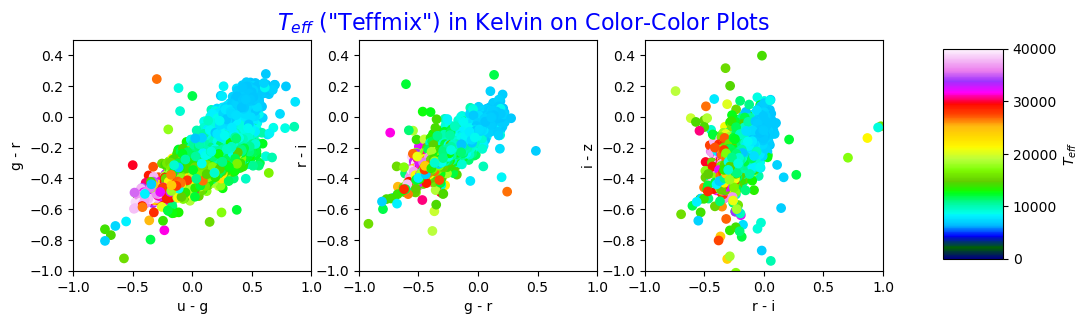

In [14]:
# These color-color plots markers are colored by effective temperature.

cmap = colormaps['gist_ncar']
fig, ax = plt.subplots(1, 3, figsize=(12,3))
for i in range(0, 3):
    im = ax[i].scatter(df_GSMWWD[color[i]], df_GSMWWD[color[i+1]], 
#                        c=df_GSMWWD["teff"], cmap=cmap)
                       c=df_GSMWWD["Teffmix"], cmap=cmap, vmin=0000., vmax=40000.)
    ax[i].set_xlabel(color_label[i])
    ax[i].set_ylabel(color_label[i+1])
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-1, .5)
    
fig.suptitle('$T_{eff}$ ("Teffmix") in Kelvin on Color-Color Plots', fontsize=16, color='blue')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='$T_{eff}$')


Text(0.5, 1.0, 'Distribution of $T_{eff}$ (TeffH)')

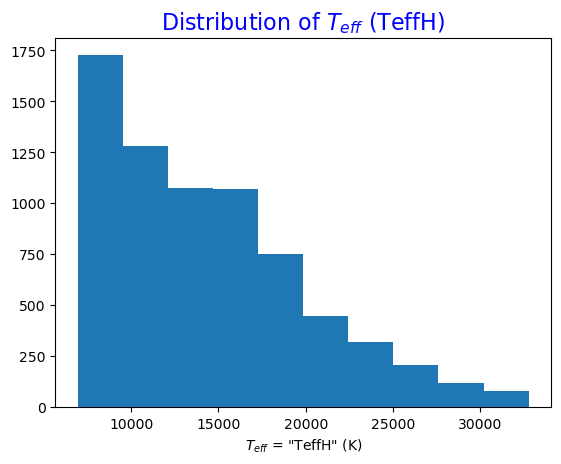

In [15]:
plt.hist(df_GSMWWD['TeffH'])
plt.xlabel('$T_{eff}$ = "TeffH" (K)')
plt.title('Distribution of $T_{eff}$ (TeffH)', fontsize=16, color='blue')

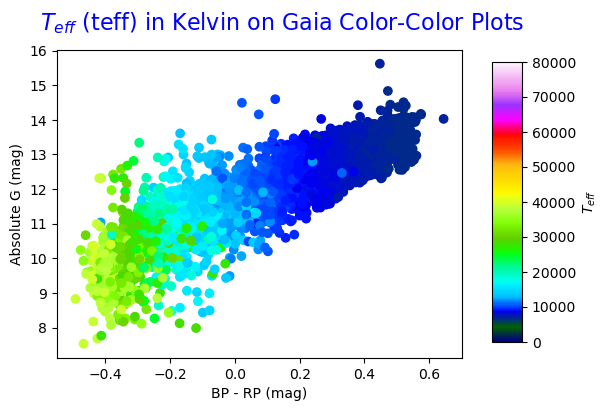

In [16]:
df_GSMWWD['BPminusRP'] = df_GSMWWD['BPmag'] - df_GSMWWD['RPmag']
df_GSMWWD['Gmag_abs'] = df_GSMWWD['Gmag'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.scatter(df_GSMWWD['BPminusRP'], df_GSMWWD['Gmag_abs'], 
#                        c=df_GSMWWD["Teffmix"], cmap=cmap)
                       c=df_GSMWWD["Teffmix"], cmap=cmap, vmin=0000., vmax=80000.)
ax.set_xlabel('BP - RP (mag)')
ax.set_ylabel('Absolute G (mag)')
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, .5)
    
fig.suptitle('$T_{eff}$ (teff) in Kelvin on Gaia Color-Color Plots', fontsize=16, color='blue')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='$T_{eff}$')


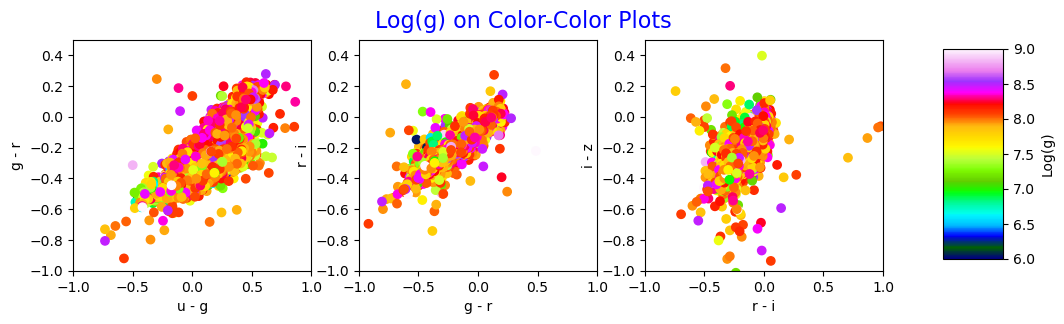

In [17]:
# These color-color plots markers are colored by log(g).

fig, ax = plt.subplots(1, 3, figsize=(12,3))
for i in range(0, 3):
    im = ax[i].scatter(df_GSMWWD[color[i]], df_GSMWWD[color[i+1]], 
#                        c=df_GSMWWD["loggH"], cmap=cmap)
                       c=df_GSMWWD["loggH"], cmap=cmap, vmin=6, vmax=9)
    ax[i].set_xlabel(color_label[i])
    ax[i].set_ylabel(color_label[i+1])
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-1, .5)
    
fig.suptitle('Log(g) on Color-Color Plots', fontsize=16, color='blue')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Log(g)')


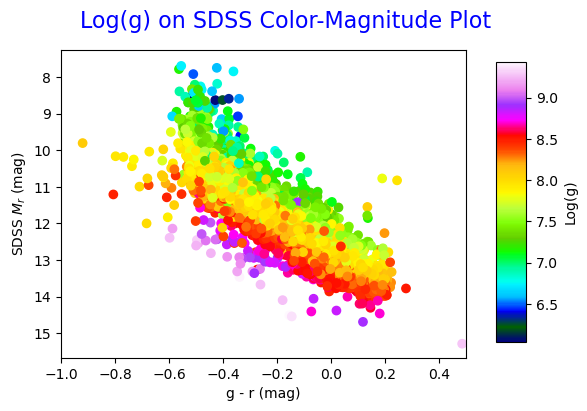

In [18]:
# Create a color_magnitude plot with log(g)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.scatter(df_GSMWWD['gr'], df_GSMWWD['r_MagAbs'], 
                       c=df_GSMWWD["loggH"], cmap=cmap)
#                        c=df_GSMWWD["loggH"], cmap=cmap, vmin=0000., vmax=80000.)
ax.set_xlabel('g - r (mag)')
ax.set_ylabel('SDSS $M_{r}$ (mag)')
ax.set_xlim(-1, .5)
# ax.set_ylim(-1, .5)
ax.invert_yaxis()
    
fig.suptitle('Log(g) on SDSS Color-Magnitude Plot', fontsize=16, color='blue')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Log(g)')


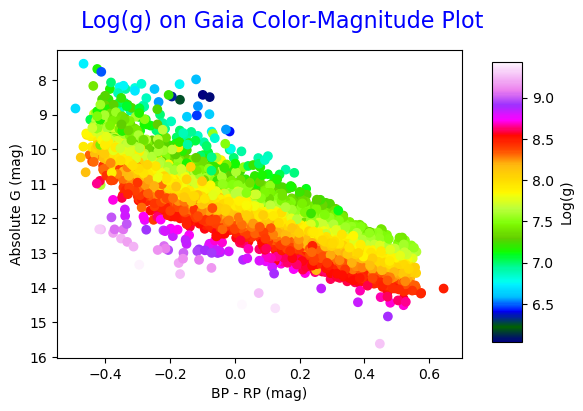

In [19]:
# Create a color_magnitude plot with log(g) using Gaia colors

df_GSMWWD['BPminusRP'] = df_GSMWWD['BPmag'] - df_GSMWWD['RPmag']
df_GSMWWD['Gmag_abs'] = df_GSMWWD['Gmag'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.scatter(df_GSMWWD['BPminusRP'], df_GSMWWD['Gmag_abs'], 
                       c=df_GSMWWD["loggH"], cmap=cmap)
#                        c=df_GSMWWD["loggH"], cmap=cmap, vmin=0000., vmax=80000.)
ax.set_xlabel('BP - RP (mag)')
ax.set_ylabel('Absolute G (mag)')
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, .5)
ax.invert_yaxis()
fig.suptitle('Log(g) on Gaia Color-Magnitude Plot', fontsize=16, color='blue')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Log(g)')


In [20]:
print('Average Fraction of Distance Error Range With Respect to the Mean')
print('Geometric Distance: %2.2f' %(np.average((df_GSMWWD['B_rgeo'] - df_GSMWWD['b_rgeo']) / df_GSMWWD['rgeo'])))
print('Photogeometric Distance: %2.2f' %(np.average((df_GSMWWD['B_rpgeo'] - df_GSMWWD['b_rpgeo']) / df_GSMWWD['rpgeo'])))


Average Fraction of Distance Error Range With Respect to the Mean
Geometric Distance: 0.07
Photogeometric Distance: 0.08


Text(0.5, 0.98, 'Geometric Distance is Closest to 1/parallax - Use Photometric Distances')

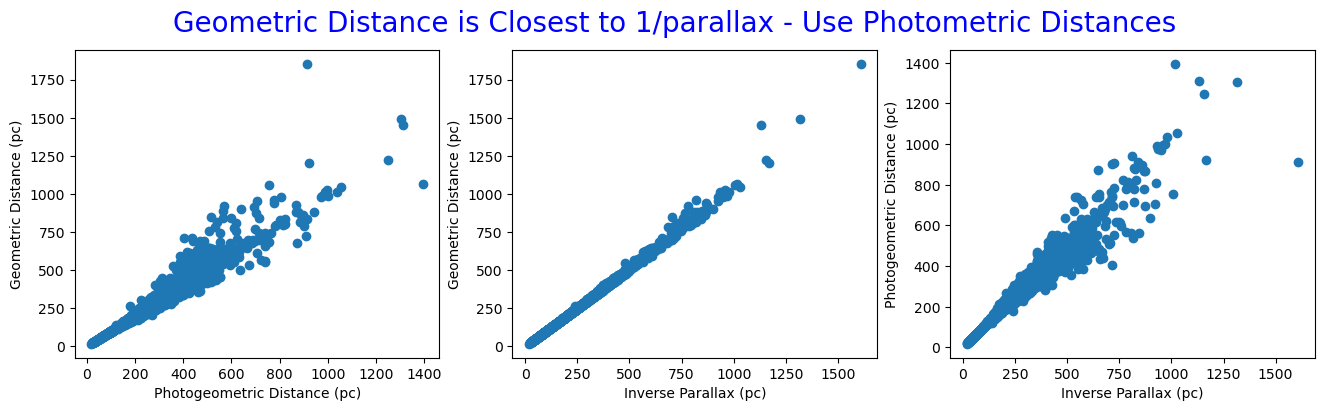

In [21]:
# Compare values for 1/parallax and the geometric and photogeometric values.

df_GSMWWD['inv_parallax'] = 1. / df_GSMWWD['Plx'] * 1000
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].scatter(df_GSMWWD['rpgeo'], df_GSMWWD['rgeo'])
ax[0].set_xlabel('Photogeometric Distance (pc)')
ax[0].set_ylabel('Geometric Distance (pc)')
ax[1].scatter(df_GSMWWD['inv_parallax'], df_GSMWWD['rgeo'])
ax[1].set_xlabel('Inverse Parallax (pc)')
ax[1].set_ylabel('Geometric Distance (pc)')
ax[2].scatter(df_GSMWWD['inv_parallax'], df_GSMWWD['rpgeo'])
ax[2].set_xlabel('Inverse Parallax (pc)')
ax[2].set_ylabel('Photogeometric Distance (pc)')
fig.suptitle('Geometric Distance is Closest to 1/parallax - Use Photogeometric Distances', 
             fontsize=20, color='blue')


##### <span style="color:blue">What types of white dwarfs are included and how many of each are there? DA's are obviously predominant, but DB and DC are worth consideration. DA's, DB's and DC's </span>

In [22]:
print('White Dwarf Database Spectral Types:')
print(df_GSMWWD.spectype.unique())
print()
print('WD Type    #')
print(df_GSMWWD.spectype.value_counts())

White Dwarf Database Spectral Types:
['DA' 'DC' 'DB']

WD Type    #
spectype
DA    5870
DB     702
DC     505
Name: count, dtype: int64


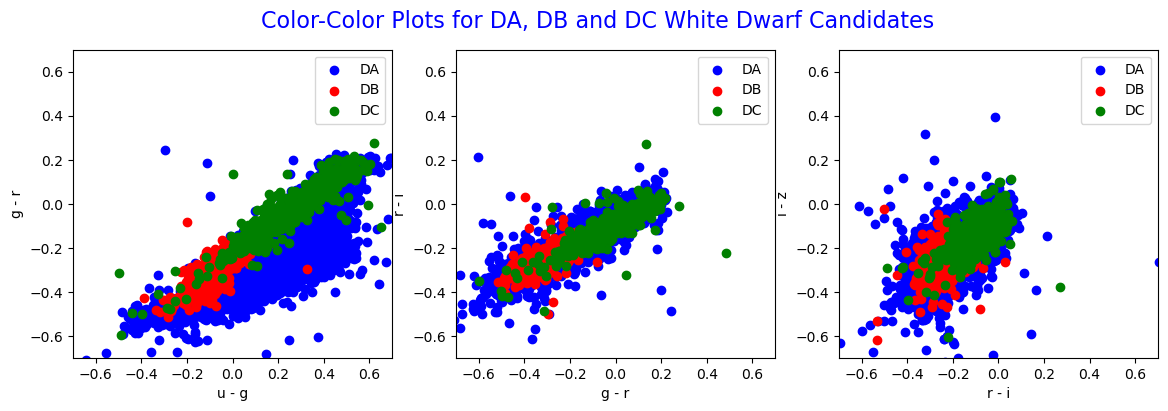

In [23]:
# Create pandas tables for DA, DB and DC white dwarfs.

df_DA = df_GSMWWD[df_GSMWWD['spectype'] == 'DA']
df_DB = df_GSMWWD[df_GSMWWD['spectype'] == 'DB']
df_DC = df_GSMWWD[df_GSMWWD['spectype'] == 'DC']

fig, ax = plt.subplots(1, 3, figsize=(14,4))

for i in range(3):
    ax[i].scatter(df_DA[color[i]], df_DA[color[i+1]], color='blue', label='DA')
    ax[i].scatter(df_DB[color[i]], df_DB[color[i+1]], color='red', label='DB')
    ax[i].scatter(df_DC[color[i]], df_DC[color[i+1]], color='green', label='DC')
    ax[i].set_xlim(-0.7, 0.7)
    ax[i].set_ylim(-0.7, 0.7)
    ax[i].legend()
    ax[i].set_xlabel(color_label[i])
    ax[i].set_ylabel(color_label[i+1])
    fig.suptitle('Color-Color Plots for DA, DB and DC White Dwarf Candidates', fontsize=16, color='blue')

In [24]:
print('Number of White Dwarfs in Each Stellar Class')
print(' DA   DB  DC')
print(len(df_DA), len(df_DB), len(df_DC))

Number of White Dwarfs in Each Stellar Class
 DA   DB  DC
5870 702 505


#### <span style='color:blue'> Make some color-magnitude plots with $M_{r}$</span>

Text(0.5, 0.98, 'SDSS Color-Magnitudes for DA, DB and DC White Dwarfs')

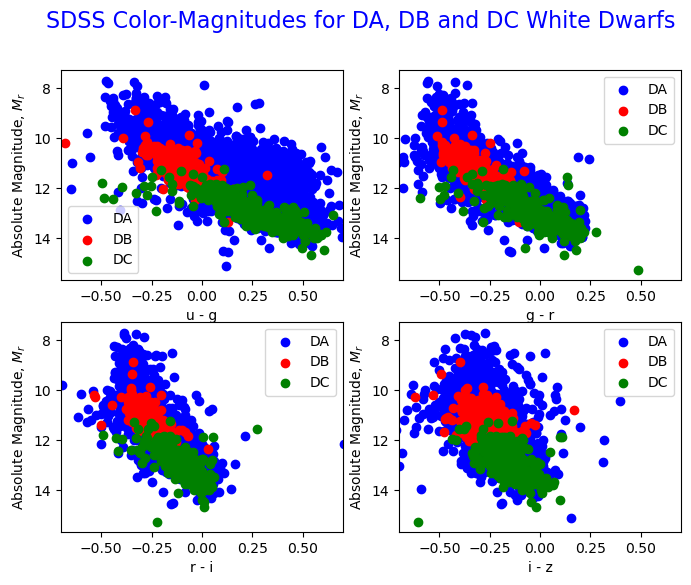

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
m = 0

for i in range(2):
    for j in range(2):
        ax[i, j].scatter(df_DA[color[m]], df_DA['r_MagAbs'], color='blue', label='DA')
        ax[i, j].scatter(df_DB[color[m]], df_DB['r_MagAbs'], color='red', label='DB')
        ax[i, j].scatter(df_DC[color[m]], df_DC['r_MagAbs'], color='green', label='DC')
        ax[i, j].set_xlim(-0.7, 0.7)
#         ax[i].set_ylim(-0.7, 0.7)
        ax[i, j].legend()
        ax[i, j].set_xlabel(color_label[m])
        ax[i, j].set_ylabel('Absolute Magnitude, $M_{r}$')
        ax[i, j].invert_yaxis()
        m +=1
        
fig.suptitle('SDSS Color-Magnitudes for DA, DB and DC White Dwarfs', fontsize=16, color='blue')

#### <span style='color:blue'> Color-magnitude plots with $M_{r}$ for DA white dwarfs only:</span>

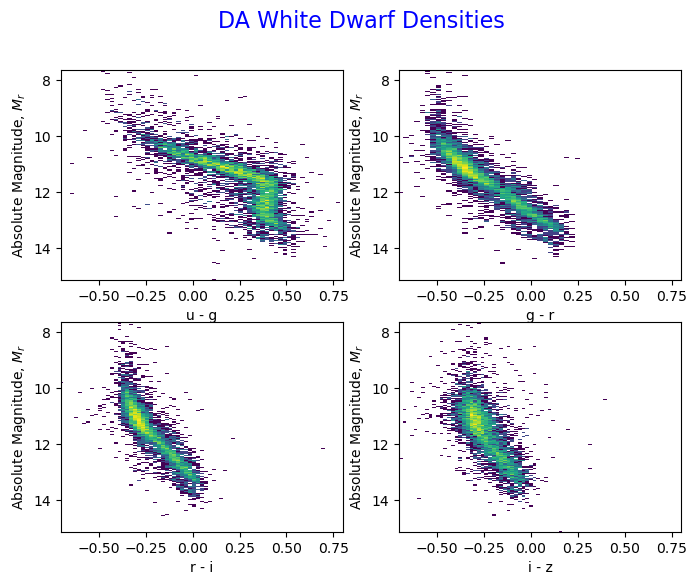

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
m = 0

fig.suptitle('DA White Dwarf Densities', fontsize=16, color='blue')
for i in range(2):
    for j in range(2):
        ax[i, j].hist2d(df_DA[color[m]], df_DA['r_MagAbs'], bins=(200,200), norm='log')
#         ax[i, j].hist2d(df_DB[color[m]], df_DB['r_MagAbs'], bins=(200,200), norm='log')
#         ax[i, j].hist2d(df_DC[color[m]], df_DC['r_MagAbs'], bins=(200,200), norm='log')
        ax[i, j].invert_yaxis()
        ax[i, j].set_xlim(-0.7, 0.8)
        ax[i, j].set_xlabel(color_label[m])
        ax[i, j].set_ylabel('Absolute Magnitude, $M_{r}$')
        
        m +=1


#### <span style='color:blue'> Color-magnitude plots with $M_{r}$ for DB white dwarfs only:</span>

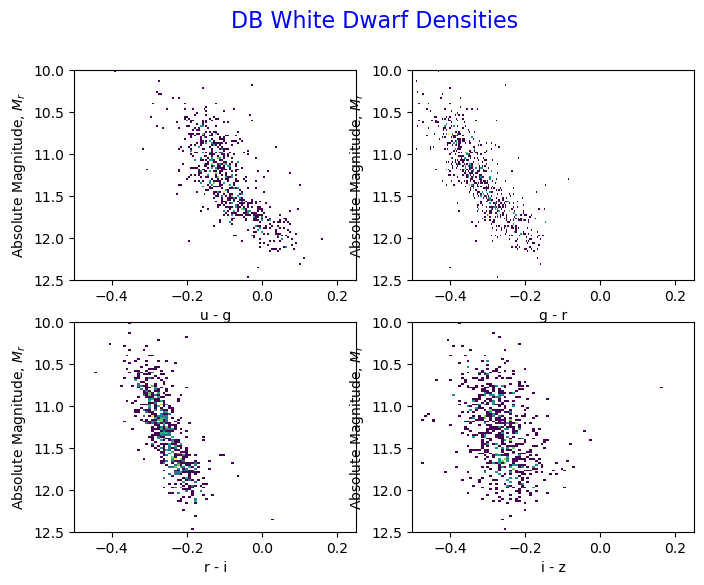

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
m = 0

fig.suptitle('DB White Dwarf Densities', fontsize=16, color='blue')
for i in range(2):
    for j in range(2):
#         ax[i, j].hist2d(df_DA[color[m]], df_DA['r_MagAbs'], bins=(200,200), norm='log')
        ax[i, j].hist2d(df_DB[color[m]], df_DB['r_MagAbs'], bins=(200,200), norm='log')
#         ax[i, j].hist2d(df_DC[color[m]], df_DC['r_MagAbs'], bins=(200,200), norm='log')
        ax[i, j].invert_yaxis()
        ax[i, j].set_xlim(-0.5, 0.25)
        ax[i, j].set_ylim(12.5, 10)
        ax[i, j].set_xlabel(color_label[m])
        ax[i, j].set_ylabel('Absolute Magnitude, $M_{r}$')
        
        m +=1


#### <span style='color:blue'> Color-magnitude plots with $M_{r}$ for DC white dwarfs only:</span>

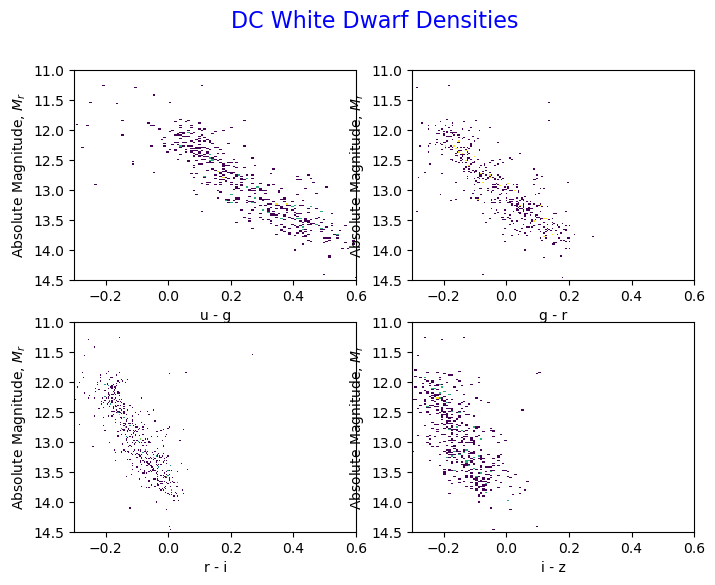

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
m = 0

fig.suptitle('DC White Dwarf Densities', fontsize=16, color='blue')
for i in range(2):
    for j in range(2):
#         ax[i, j].hist2d(df_DA[color[m]], df_DA['r_MagAbs'], bins=(200,200), norm='log')
#         ax[i, j].hist2d(df_DB[color[m]], df_DB['r_MagAbs'], bins=(200,200), norm='log')
        ax[i, j].hist2d(df_DC[color[m]], df_DC['r_MagAbs'], bins=(200,200), norm='log')
        ax[i, j].invert_yaxis()
        ax[i, j].set_xlim(-0.3, 0.6)
        ax[i, j].set_ylim(14.5, 11)
        ax[i, j].set_xlabel(color_label[m])
        ax[i, j].set_ylabel('Absolute Magnitude, $M_{r}$')
        
        m +=1


#### <span style='color:blue'> Add some functions for modeling the data and evaluating its effectiveness. Bin the data from the medians. Some of these are direct from Željko.</span>

In [29]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 

def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [30]:
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

In [31]:
def bestFitPlot(xBin, medianBin):
    x = xBin
    sigma_y = 0.1 + 0*x
    y = medianBin 
    # data = np.array([x, y, sigma_y])

    # get best-fit parameters for linear, quadratic and cubic models
    theta1 = best_theta(1, x, y, sigma_y)
    theta2 = best_theta(2, x, y, sigma_y)
    theta3 = best_theta(3, x, y, sigma_y)
    theta4 = best_theta(4, x, y, sigma_y)
    theta5 = best_theta(5, x, y, sigma_y)
    theta6 = best_theta(6, x, y, sigma_y)

    # generate best fit lines on a fine grid 
    xfit = np.linspace(-0.1, 3.1, 1000)
    yfit1 = polynomial_fit(theta1, xfit)
    yfit2 = polynomial_fit(theta2, xfit)
    yfit3 = polynomial_fit(theta3, xfit)
    yfit4 = polynomial_fit(theta4, xfit)
    yfit5 = polynomial_fit(theta5, xfit)
    yfit6 = polynomial_fit(theta6, xfit)


    # plot 
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
    ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
    ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
    ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
    ax.plot(xfit, polynomial_fit(theta4, xfit), label='best 4-th order model')
    ax.plot(xfit, polynomial_fit(theta5, xfit), label='best 5-th order model')
    ax.plot(xfit, polynomial_fit(theta6, xfit), label='best 6-th order model')

    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel('Color')
    ax.set_ylabel('$M_{r}$')
    ax.set_title('Comparison of Polynomial Fits', fontsize=16, color='blue')
    
    return x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6


In [32]:
def calcBestFit(x, y, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6):
    # compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
    chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
    chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
    chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
    chi24 = np.sum(((y-polynomial_fit(theta4, x))/sigma_y)**2) 
    chi25 = np.sum(((y-polynomial_fit(theta5, x))/sigma_y)**2) 
    chi26 = np.sum(((y-polynomial_fit(theta6, x))/sigma_y)**2) 


    # the number of fitted parameters is 2, 3, 4, 5, 6
    BIC1 = chi21 + 2*np.log(nBins)
    BIC2 = chi22 + 3*np.log(nBins)
    BIC3 = chi23 + 4*np.log(nBins)
    BIC4 = chi24 + 5*np.log(nBins)
    BIC5 = chi25 + 6*np.log(nBins)
    BIC6 = chi26 + 7*np.log(nBins)


    print ("         MODEL             CHI2          BIC")
    print ('    best linear model:', chi21, BIC1)
    print (' best quadratic model:', chi22, BIC2)
    print ('     best cubic model:', chi23, BIC3)
    print ('best 4-th order model:', chi24, BIC4)
    print ('best 5-th order model:', chi25, BIC5)
    print ('best 6-th order model:', chi26, BIC6)

In [33]:
def optimizeDist(color, mag, xMin, xMax, nBins):
    # xMin and xMax are generally lower and higher than the bulk of the data, so input
    # them into the object manually.
    xBin, nPts, medianBin, sigGbin = fitMedians(color, mag, xMin, 
                                                xMax, nBins, verbose=0)

    # where Nbin is about 8, that is, the color step is 0.1 mag (though 0.05 mag would be
    # better if the sample allows it).
    # The main purpose of this step is to avoid outliers having an impact on the final fit (median
    # is a robust estimator, unlike mean).

    print('xBins  ', 'medianBin  ', 'SigmaGBin', '    # Pts.  ')
    for i in range(nBins):
        print('%2.3f      %2.2f        %2.2f    %8d' %(xBin[i], medianBin[i], sigGbin[i], nPts[i]))
    
    plt.scatter(xBin, medianBin, label='median bin')
    plt.scatter(xBin, sigGbin, color='red', label='sigB bin')
    plt.xlabel('xBin')
    plt.legend(loc='center left')
    plt.gca().invert_yaxis()
    plt.xlabel('color bin')
    plt.ylabel('Absolute r Magnitude')
    plt.title('Binned Medians Given a Color Range and the Number of Bins', fontsize=16, color='blue')

    return xBin, medianBin, sigGbin

### <span style="color:blue">III. Model White Dwarf DA, DB and DC colors</span>
<span style="color:blue">Bin SDSS colors vs. absolute magnitude and usse the median value. Evaluate the fits.</span>


In [34]:
Mr = [8.50]
delta_M = 0.02
for i in range(300):
   Mr.append(Mr[i] + delta_M)

print('%.2f ≤ $M_{r} ≤ %.2f' %(Mr[0], Mr[300]))

8.50 ≤ $M_{r} ≤ 14.50


#### <span style='color:blue'> III.1a DA for u - g

In [35]:
xMin = np.min(df_DA['ug'])
xMax = np.max(df_DA['ug'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -1.740, 2.982


xBins   medianBin   SigmaGBin     # Pts.  
-0.173      10.39        0.03         101
-0.138      10.39        0.03         117
-0.104      10.55        0.02         157
-0.069      10.61        0.02         146
-0.035      10.68        0.02         164
-0.000      10.81        0.02         179
0.034      10.91        0.02         184
0.069      10.92        0.02         231
0.103      11.01        0.02         202
0.138      11.05        0.02         213
0.172      11.15        0.02         233
0.207      11.24        0.02         250
0.241      11.30        0.02         284
0.276      11.42        0.04         276
0.310      11.66        0.06         315
0.345      12.03        0.04         487
0.379      12.30        0.03         681
0.414      12.27        0.04         593
0.448      12.36        0.06         379
0.483      12.84        0.09         192


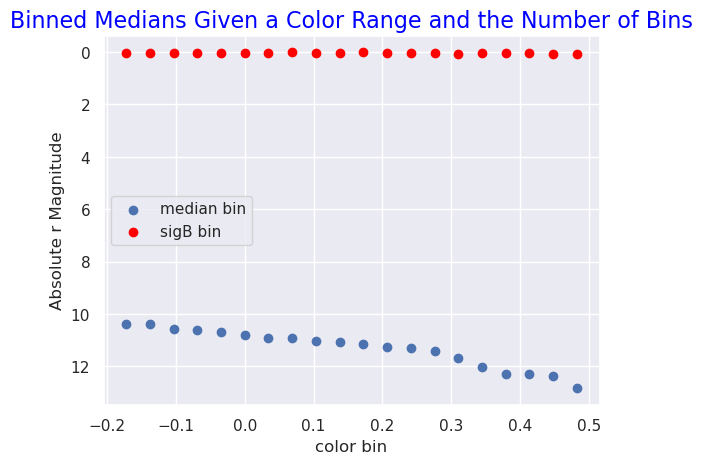

In [36]:
nBins = 20
xBin, medianBin, sigGbin = optimizeDist(df_DA['ug'], df_DA['r_MagAbs'], xMin=-.19, 
                                       xMax=0.50, nBins=nBins)

         MODEL             CHI2          BIC
    best linear model: 67.74759232508777 73.73905687219575
 best quadratic model: 21.288125274717466 30.275322095379437
     best cubic model: 15.545596241133529 27.528525335349492
best 4-th order model: 14.512956520919579 29.491617888689532
best 5-th order model: 12.879360742933105 30.85375438425705
best 6-th order model: 11.00709452231488 31.977220437192816


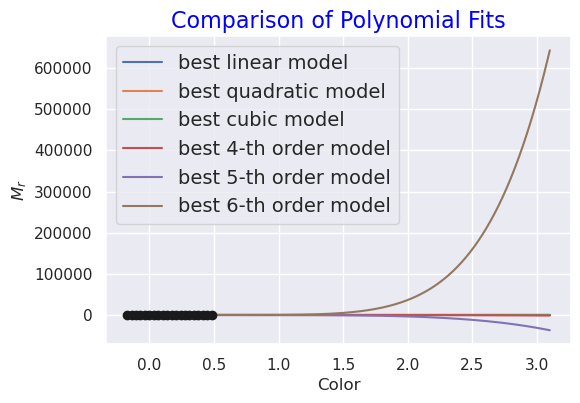

In [37]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)

Coefficients of the polynomial fit are 8.7849, 0.2370, 2.0856, 10.7620 


Text(0.5, 1.0, 'Polynomial Fit of Degree 3 to Data')

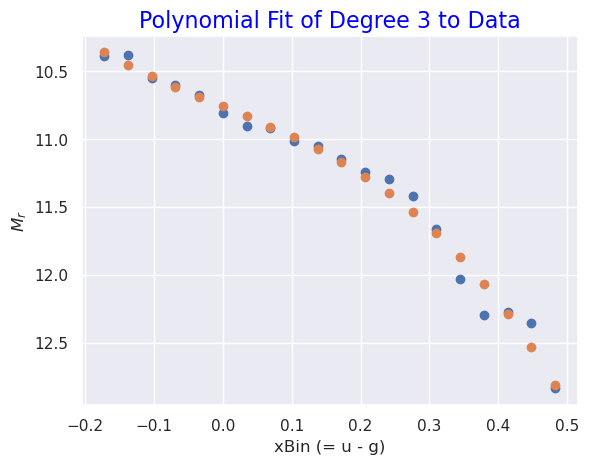

In [38]:
# Find the coefficients that best fit the data, given the polynomial degree,
# and plot the result

degree = 3
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f, %.4f ' %(z[0], z[1], z[2], z[3]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**3 + z[1]*xBin**2 + z[2]*xBin + z[3]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= u - g)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


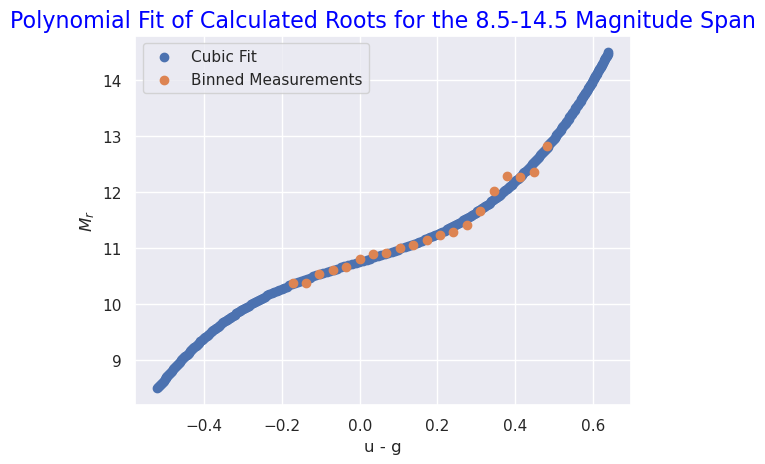

In [39]:
# Calculate the roots of your polynomial fit
DAug_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2], z[3]- Mr[i]]
#   finding the roots of the cubic equation
    DAug_roots.append(np.roots(z2)[2])

plt.scatter(DAug_roots, Mr, label='Cubic Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('u - g')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit of Calculated Roots for the 8.5-14.5 Magnitude Span', fontsize=16, color='blue')
plt.legend(loc='upper left')

#### <span style='color:blue'> III.1b DA for g - r

In [40]:
xMin = np.min(df_DA['gr'])
xMax = np.max(df_DA['gr'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -2.188, 3.512


xBins   medianBin   SigmaGBin     # Pts.  
-0.484      10.22        0.05         215
-0.452      10.50        0.02         329
-0.421      10.72        0.02         367
-0.389      10.89        0.01         524
-0.357      11.09        0.01         542
-0.325      11.25        0.01         495
-0.294      11.41        0.01         360
-0.262      11.53        0.02         287
-0.230      11.68        0.02         276
-0.198      11.78        0.03         179
-0.167      11.95        0.04         170
-0.135      12.11        0.02         214
-0.103      12.25        0.02         266
-0.071      12.40        0.02         264
-0.040      12.53        0.02         240
-0.008      12.69        0.02         213
0.024      12.82        0.02         174
0.056      13.00        0.02         167
0.087      13.12        0.03         139
0.119      13.22        0.02         132


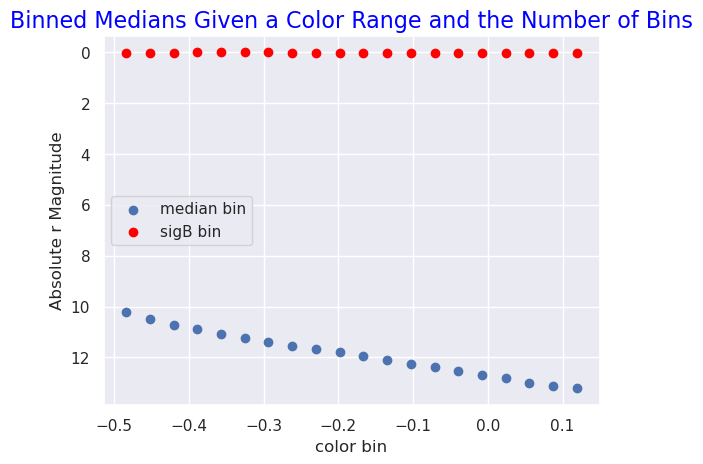

In [41]:
nBins = 20
xBin, medianBin, sigGbin = optimizeDist(df_DA['gr'], df_DA['r_MagAbs'], xMin=-.5, 
                                       xMax=0.135, nBins=nBins)

         MODEL             CHI2          BIC
    best linear model: 7.555820322273331 13.547284869381313
 best quadratic model: 3.358506335416347 12.34570315607832
     best cubic model: 1.5763748558478954 13.559303950063859
best 4-th order model: 0.28726945389255637 15.26593082166251
best 5-th order model: 0.2857915292027812 18.26018517052673
best 6-th order model: 0.2857890752414456 21.255914990119383


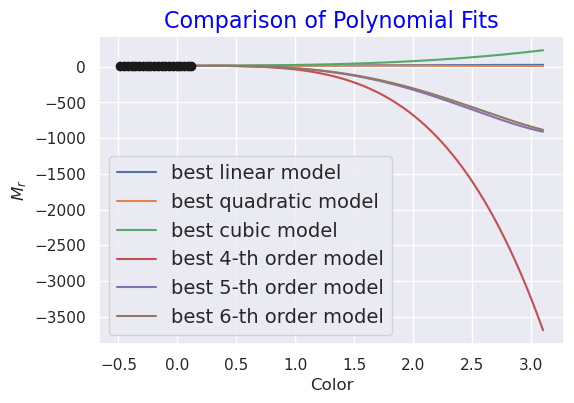

In [42]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are -1.5339, 4.2207, 


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

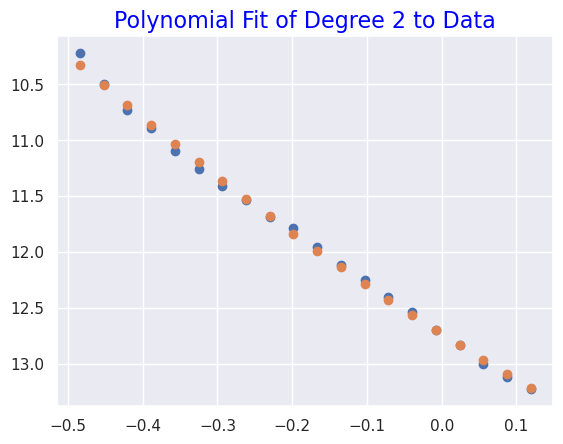

In [43]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, ' %(z[0], z[1]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


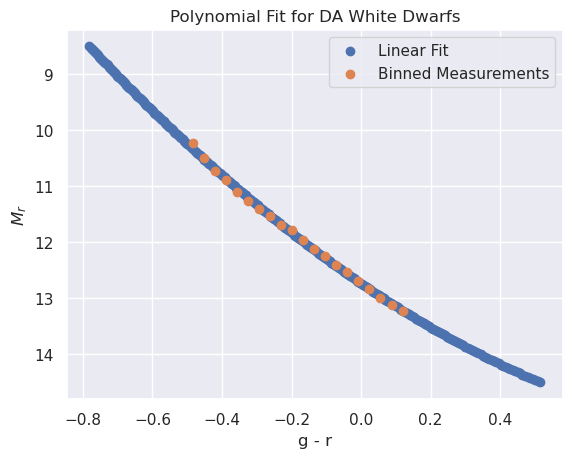

In [44]:
# Calculate the roots of your polynomial fit
DAgr_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DAgr_roots.append(np.roots(z2)[1])

plt.scatter(DAgr_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('g - r')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DA White Dwarfs')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()


#### <span style='color:blue'> III.1c DA for r - i

In [45]:
xMin = np.min(df_DA['ri'])
xMax = np.max(df_DA['ri'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -2.569, 1.604


xBins   medianBin   SigmaGBin     # Pts.  
-0.361      10.33        0.04         218
-0.342      10.51        0.03         321
-0.324      10.74        0.02         460
-0.305      10.92        0.02         532
-0.287      11.14        0.02         559
-0.268      11.27        0.02         466
-0.250      11.40        0.02         355
-0.231      11.53        0.03         277
-0.213      11.71        0.02         222
-0.194      11.85        0.03         170
-0.176      11.96        0.03         178
-0.157      12.11        0.03         188
-0.139      12.21        0.03         167
-0.120      12.33        0.03         193
-0.102      12.44        0.02         229
-0.083      12.58        0.02         212
-0.065      12.68        0.03         185
-0.046      12.86        0.02         167
-0.028      12.97        0.03         164
-0.009      13.11        0.03         159


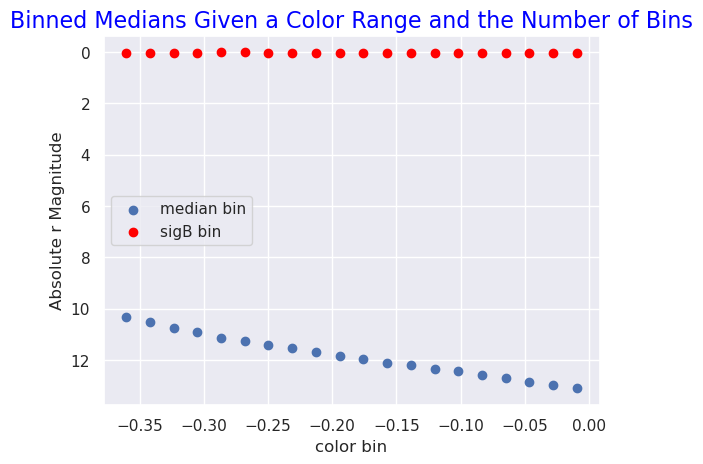

In [46]:
nBins = 20
xBin, medianBin, sigGbin = optimizeDist(df_DA['ri'], df_DA['r_MagAbs'], xMin=-.37, 
                                       xMax=0., nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 10.134953289579876 16.126417836687857
 best quadratic model: 2.723686078915995 11.710882899577967
     best cubic model: 0.6111705791758525 12.594099673391815
best 4-th order model: 0.6086036905121204 15.587265058282075
best 5-th order model: 0.6085634503072819 18.58295709163123
best 6-th order model: 0.6085645389353642 21.5786904538133


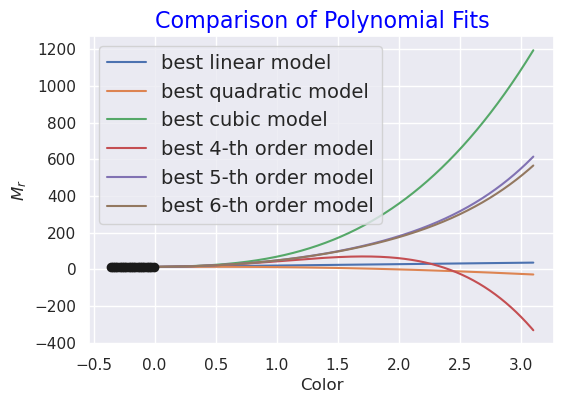

In [47]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are -6.0033, 5.3724, 13.1001       


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

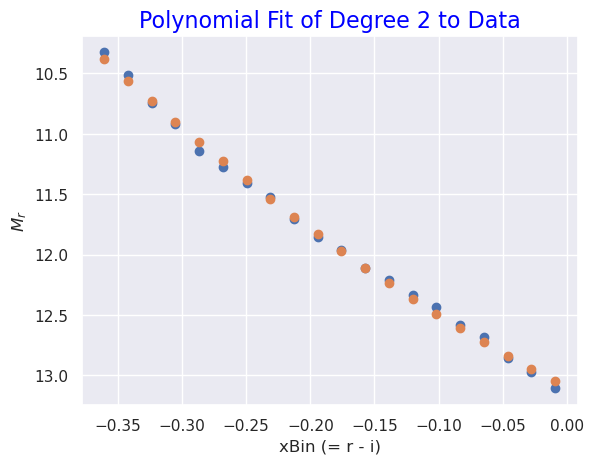

In [48]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f \
      ' %(z[0], z[1], z[2]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= r - i)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


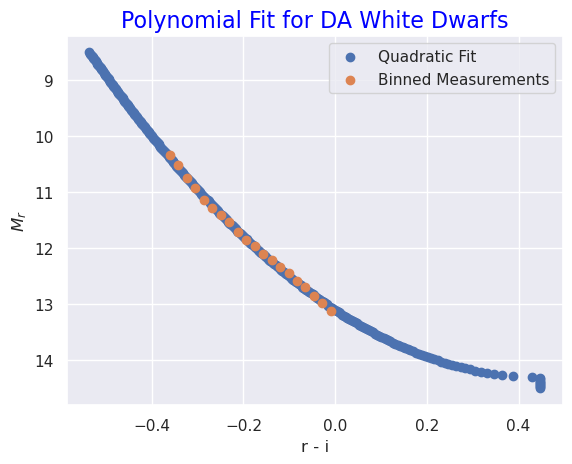

In [49]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DAri_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DAri_roots.append(np.roots(z2)[1])

plt.scatter(DAri_roots, Mr, label='Quadratic Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('r - i')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DA White Dwarfs', fontsize=16, color='blue')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

#### <span style='color:blue'> III.1d DA for i - z

In [50]:
xMin = np.min(df_DA['iz'])
xMax = np.max(df_DA['iz'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -2.067, 1.891


xBins   medianBin   SigmaGBin     # Pts.  
-0.369      10.82        0.05         212
-0.348      10.77        0.04         322
-0.327      10.93        0.03         499
-0.306      11.05        0.03         572
-0.284      11.19        0.03         624
-0.263      11.35        0.03         490
-0.242      11.48        0.04         427
-0.221      11.72        0.04         356
-0.199      12.05        0.05         295
-0.178      12.23        0.04         294
-0.157      12.49        0.04         293
-0.136      12.57        0.04         261
-0.114      12.80        0.04         235
-0.093      12.93        0.04         216
-0.072      13.03        0.05         158
-0.051      13.14        0.06         117


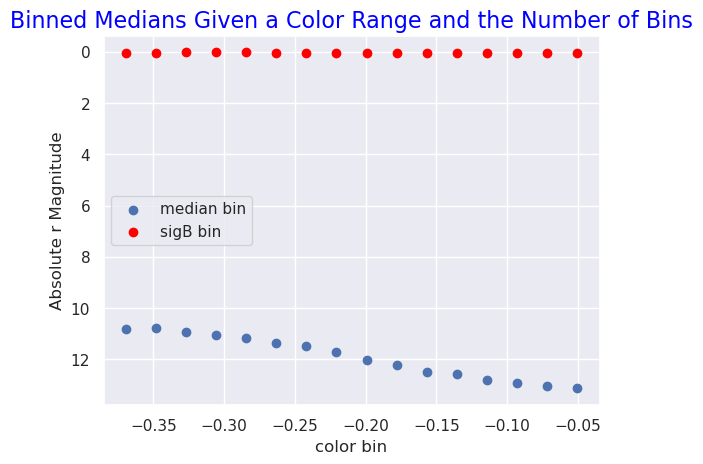

In [51]:
nBins = 16
xBin, medianBin, sigGbin = optimizeDist(df_DA['iz'], df_DA['r_MagAbs'], xMin=-.38, 
                                       xMax=-0.04, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 17.091128982530307 22.63630642700987
 best quadratic model: 15.864391305736309 24.18215747245565
     best cubic model: 2.572524645968959 13.662879534928084
best 4-th order model: 2.559922314111563 16.422865925310468
best 5-th order model: 2.3116945911795588 18.947226924618246
best 6-th order model: 2.336605873167623 21.74472692884609


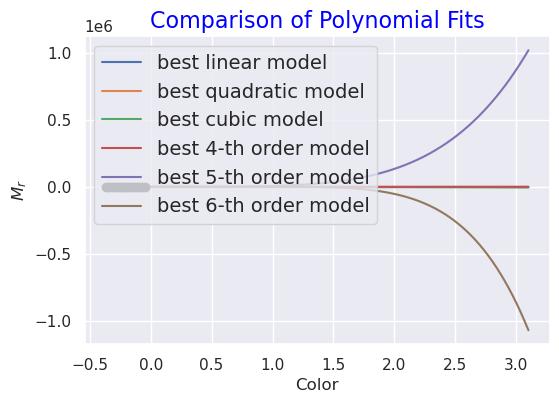

In [52]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 3.2454, 9.6473, 13.7608       


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

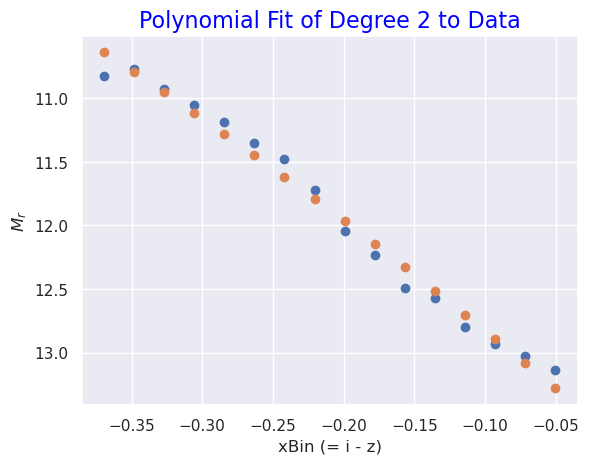

In [53]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f \
      ' %(z[0], z[1], z[2]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= i - z)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


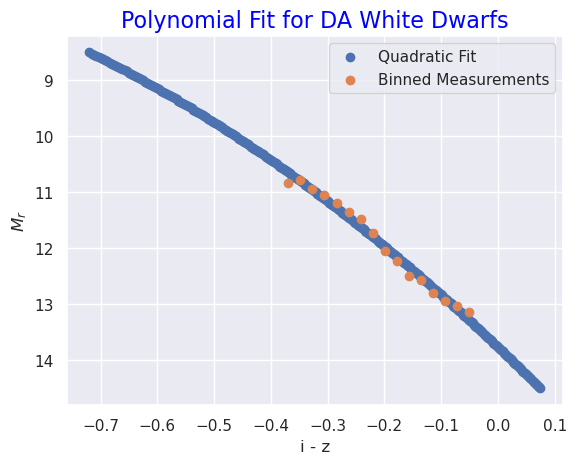

In [54]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DAiz_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DAiz_roots.append(np.roots(z2)[1])
#     print(np.roots(z2)[0])

plt.scatter(DAiz_roots, Mr, label='Quadratic Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('i - z')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit for DA White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')

#### <span style='color:purple'> Median List for DA White Dwarfs is Complete </span>

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Color Magnitude Fits for DA White Dwarfs')

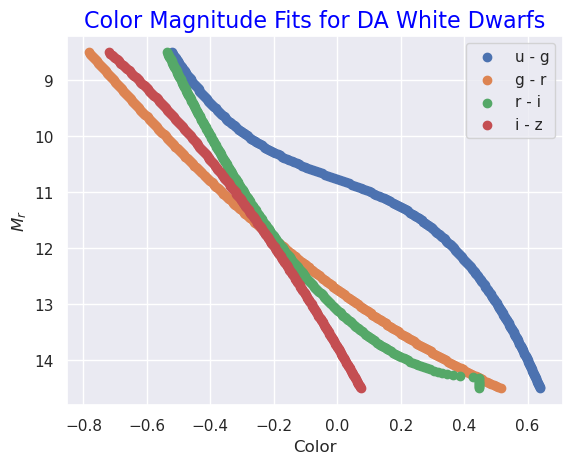

In [55]:
plt.scatter(DAug_roots, Mr, label='u - g')
plt.scatter(DAgr_roots, Mr, label='g - r')
plt.scatter(DAri_roots, Mr, label='r - i')
plt.scatter(DAiz_roots, Mr, label='i - z')
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('$M_{r}$')
plt.legend()
plt.title('Color Magnitude Fits for DA White Dwarfs', fontsize=16, color='blue')

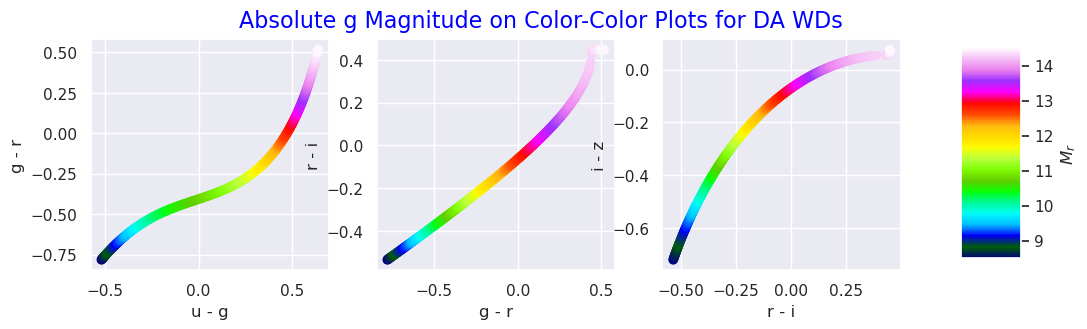

In [56]:
# These color-color plots markers are colored by absolute g magnitude.

cmap = colormaps['gist_ncar']
fig, ax = plt.subplots(1, 3, figsize=(12,3))
im = ax[0].scatter(DAug_roots, DAgr_roots, c = Mr, cmap=cmap)
im = ax[1].scatter(DAgr_roots, DAri_roots, c = Mr, cmap=cmap)
im = ax[2].scatter(DAri_roots, DAiz_roots, c = Mr, cmap=cmap)
for i in range(3):
    ax[i].set_xlabel(filter[i] + ' - ' + filter[i+1])
    ax[i].set_ylabel(filter[i+1] + ' - ' + filter[i+2])
#    ax[i].set_xlim(-1, 1)
#    ax[i].set_ylim(-1, 1)
 
fig.suptitle('Absolute g Magnitude on Color-Color Plots for DA WDs', fontsize=16, color='blue')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='$M_{r}$')

#### <span style='color:blue'> Calculate $M_{r}$ for DB colors

#### <span style='color:green'> III.2a DB for u - g

In [57]:
xMin = np.min(df_DB['ug'])
xMax = np.max(df_DB['ug'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.732, 0.325


xBins   medianBin   SigmaGBin     # Pts.  
-0.169      10.98        0.06          56
-0.146      11.04        0.05          67
-0.124      11.14        0.03         110
-0.101      11.20        0.05          88
-0.079      11.43        0.04          86
-0.056      11.55        0.03          58
-0.034      11.67        0.02          37
-0.011      11.77        0.02          49


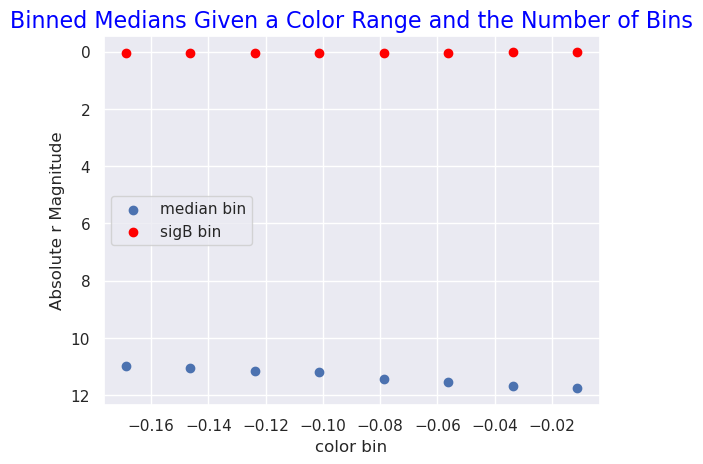

In [58]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DB['ug'], df_DB['r_MagAbs'], 
                                        xMin=-.18, xMax=0., nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 1.4295216584970563 5.588404741856728
 best quadratic model: 1.0985608913313558 7.336885516370863
     best cubic model: 0.47403506310528076 8.791801229824625
best 4-th order model: 0.4776090718007102 10.87481678019989
best 5-th order model: 0.4416868762749506 12.918336126353964
best 6-th order model: 0.47806599939028915 15.034156791149138


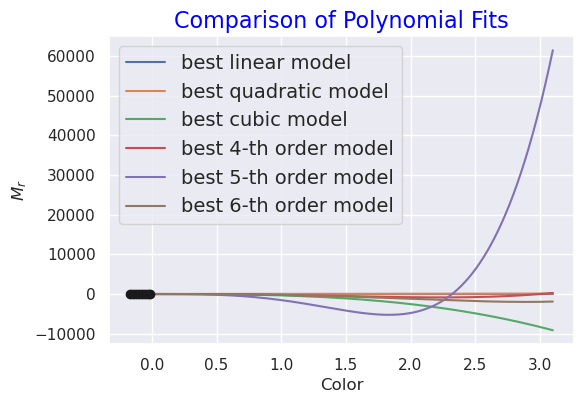

In [59]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 5.3610, 11.8306 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

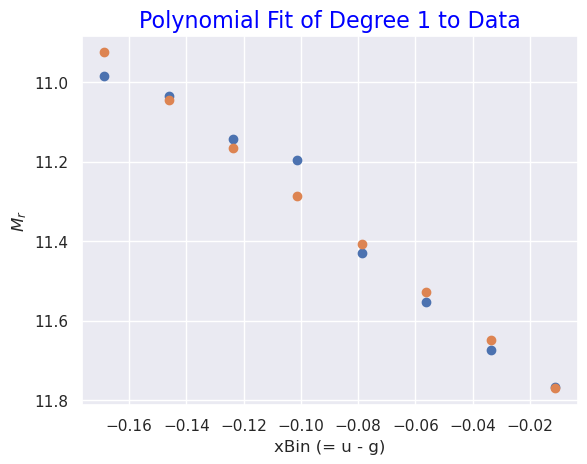

In [60]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= u - g)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


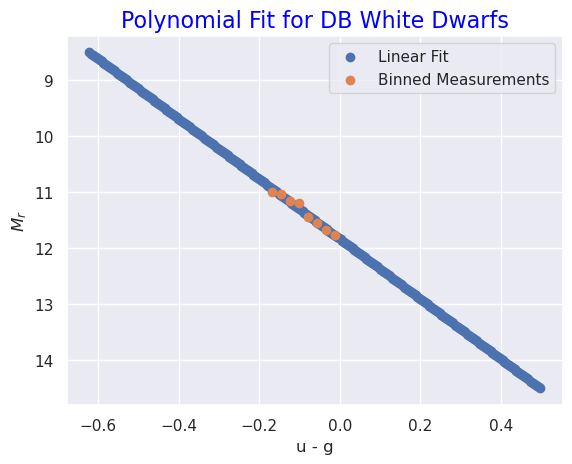

In [61]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBug_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBug_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBug_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('u - g')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')

#### <span style='color:green'> III.2b DB for g - r

In [62]:
xMin = np.min(df_DB['gr'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))
print(xMin, xMax)

xMin, xMax = -0.769, 0.325
-0.7688403129577637 0.3246733024716377


xBins   medianBin   SigmaGBin     # Pts.  
-0.402      10.87        0.07          27
-0.390      10.87        0.04          37
-0.379      10.89        0.04          47
-0.367      11.04        0.05          36
-0.355      11.12        0.03          43
-0.343      11.17        0.03          59
-0.332      11.25        0.06          40
-0.320      11.28        0.04          44
-0.308      11.41        0.04          42
-0.296      11.55        0.04          45
-0.285      11.63        0.04          35
-0.273      11.63        0.04          34
-0.261      11.65        0.04          20
-0.249      11.73        0.05          23
-0.238      11.71        0.04          21
-0.226      11.84        0.04          27


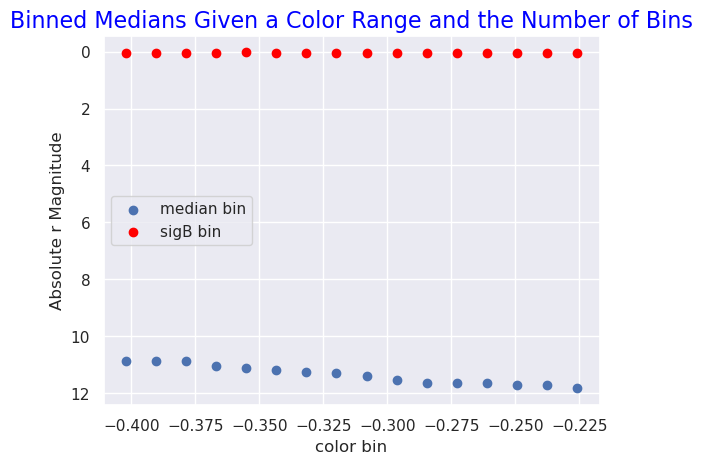

In [63]:
nBins = 16
xBin, medianBin, sigGbin = optimizeDist(df_DB['gr'], df_DB['r_MagAbs'], 
                                        xMin=-.408, xMax=-0.22, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 4.384011761257788 9.92918920573735
 best quadratic model: 3.4989340336706576 11.81670020039
     best cubic model: 2.455239157199588 13.545594046158712
best 4-th order model: 2.0523995297642506 15.915343140963156
best 5-th order model: 2.06666789610099 18.702200229539677
best 6-th order model: 2.076139002950782 21.48426005862925


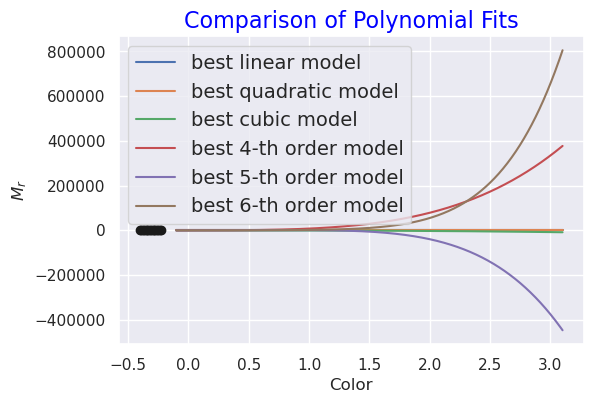

In [64]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 5.8891, 13.2004 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

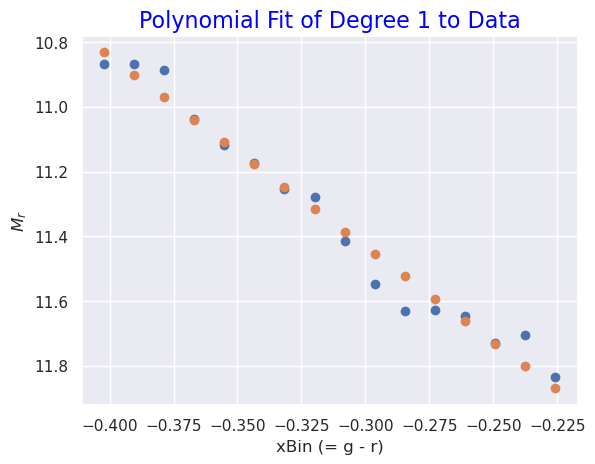

In [65]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= g - r)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


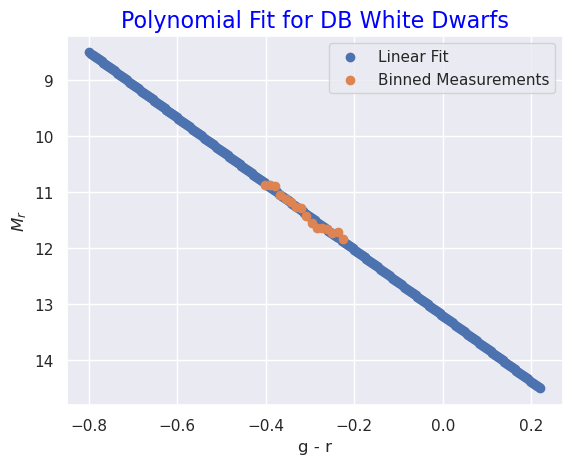

In [66]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBgr_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBgr_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBgr_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('g - r')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

#### <span style='color:green'> III.2c DB for r - i

In [67]:
xMin = np.min(df_DB['ri'])
xMax = np.max(df_DB['ri'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -1.484, 0.030


xBins   medianBin   SigmaGBin     # Pts.  
-0.307      10.85        0.05          49
-0.292      11.01        0.03          77
-0.278      11.12        0.04          74
-0.263      11.23        0.03         112
-0.247      11.33        0.03          77
-0.232      11.61        0.03          72
-0.218      11.64        0.03          63
-0.203      11.77        0.04          40


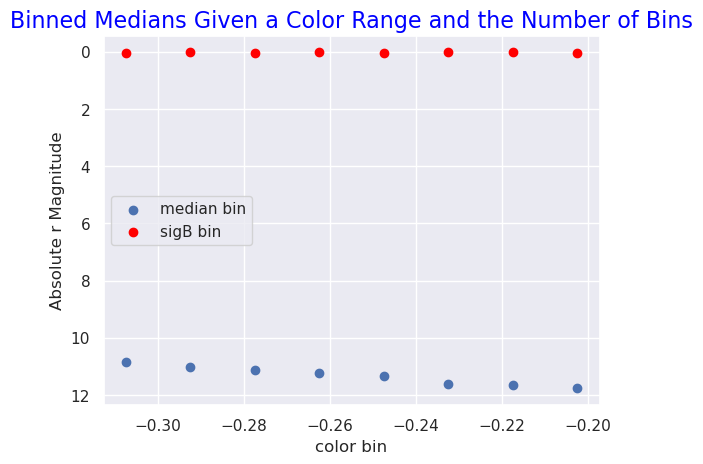

In [68]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DB['ri'], df_DB['r_MagAbs'], 
                                        xMin=-.315, xMax=-0.195, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 1.3648812141383149 5.523764297497986
 best quadratic model: 1.3648535453044064 7.603178170343913
     best cubic model: 1.279283573934926 9.597049740654269
best 4-th order model: 1.2841529300828738 11.681360638482053
best 5-th order model: 1.286624042737032 13.763273292816045
best 6-th order model: 1.2875626719642919 15.843653463723141


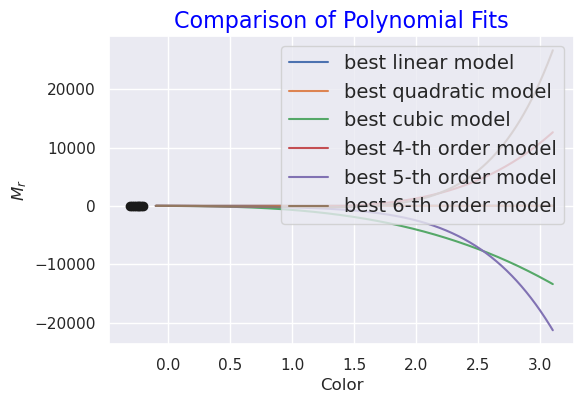

In [69]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 8.8759, 13.5832 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

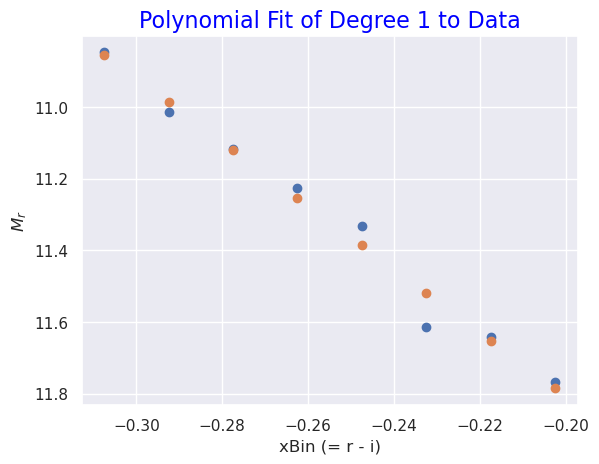

In [70]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= r - i)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


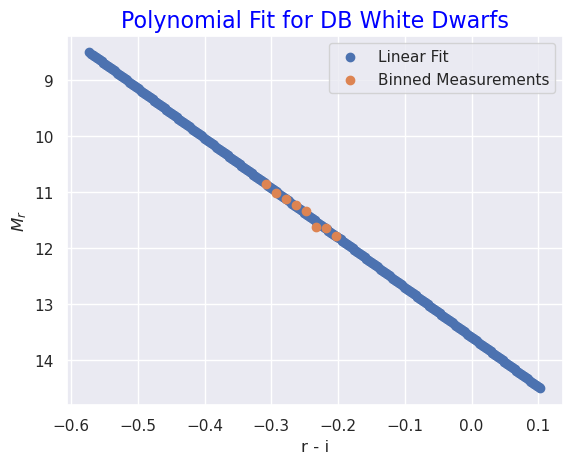

In [71]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBri_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBri_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBri_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('r - i')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

#### <span style='color:green'> III.2d DB for i - z

In [72]:
xMin = np.min(df_DB['iz'])
xMax = np.max(df_DB['iz'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.621, 0.894


xBins   medianBin   SigmaGBin     # Pts.  
-0.323      11.04        0.08          33
-0.309      11.14        0.07          61
-0.296      11.11        0.07          56
-0.282      11.20        0.07          64
-0.268      11.26        0.07          80
-0.254      11.33        0.07          60
-0.241      11.45        0.07          66
-0.227      11.51        0.07          42


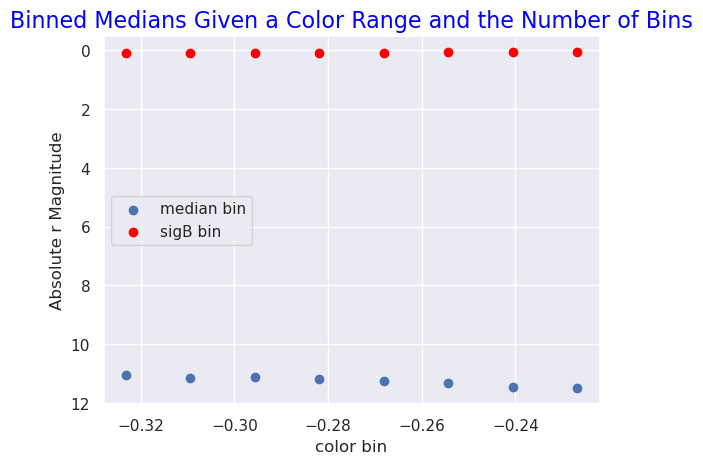

In [73]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DB['iz'], df_DB['r_MagAbs'], 
                                        xMin=-.33, xMax=-0.22, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 0.8587331315944601 5.017616214954131
 best quadratic model: 0.48192726826034504 6.720251893299852
     best cubic model: 0.4818695121176447 8.799635678836987
best 4-th order model: 0.48200586288416136 10.87921357128334
best 5-th order model: 0.4815996002561105 12.958248850335124
best 6-th order model: 0.4814507127042517 15.037541504463102


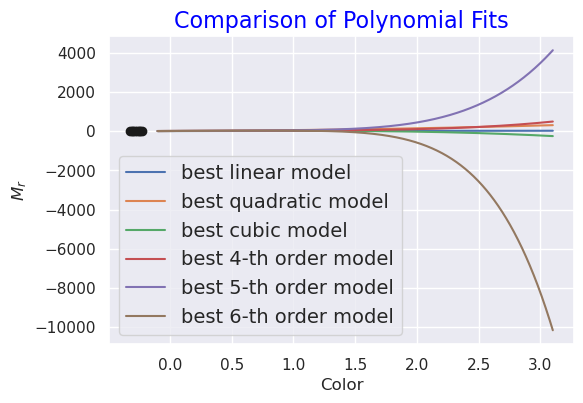

In [74]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are  4.8304, 12.5816 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

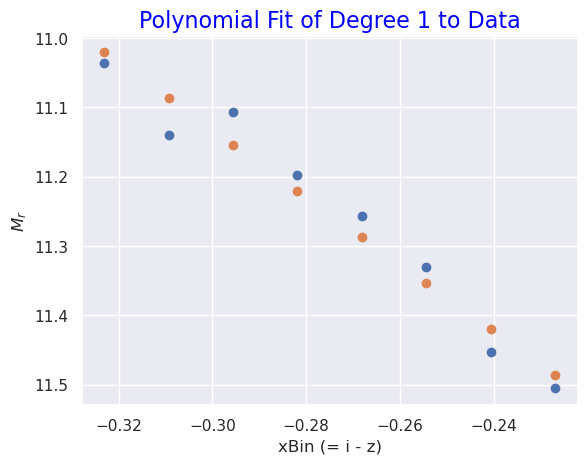

In [75]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are  %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= i - z)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


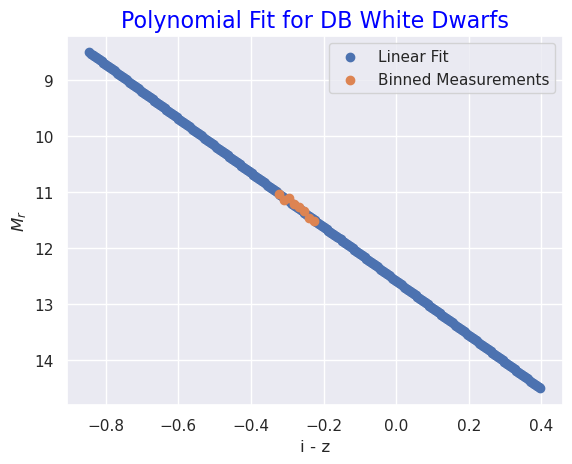

In [76]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBiz_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBiz_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBiz_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('i - z')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Color Magnitude Fits for DB White Dwarfs')

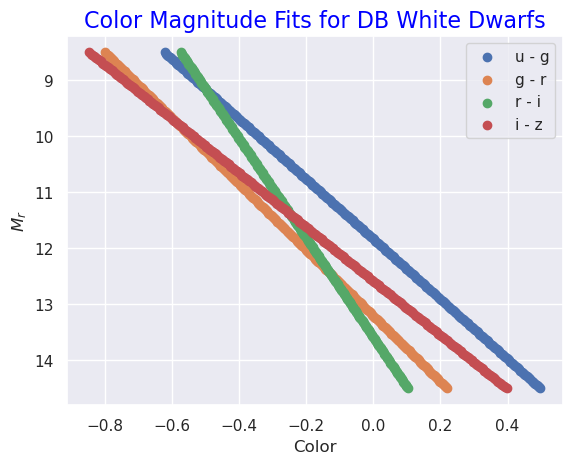

In [77]:
# Plot all colors together (with Mag)

plt.scatter(DBug_roots, Mr, label='u - g')
plt.scatter(DBgr_roots, Mr, label='g - r')
plt.scatter(DBri_roots, Mr, label='r - i')
plt.scatter(DBiz_roots, Mr, label='i - z')
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('$M_{r}$')
plt.legend()
plt.title('Color Magnitude Fits for DB White Dwarfs', fontsize=16, color='blue')

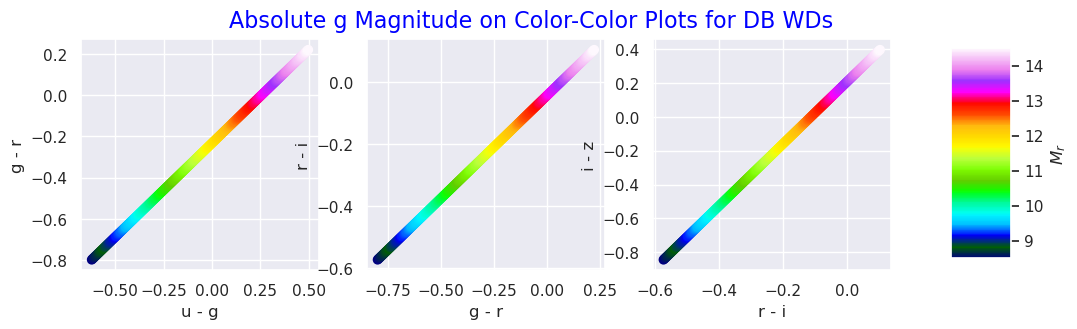

In [78]:
# These color-color plots markers are colored by absolute g magnitude.

cmap = colormaps['gist_ncar']
fig, ax = plt.subplots(1, 3, figsize=(12,3))
im = ax[0].scatter(DBug_roots, DBgr_roots, c = Mr, cmap=cmap)
im = ax[1].scatter(DBgr_roots, DBri_roots, c = Mr, cmap=cmap)
im = ax[2].scatter(DBri_roots, DBiz_roots, c = Mr, cmap=cmap)
for i in range(3):
    ax[i].set_xlabel(filter[i] + ' - ' + filter[i+1])
    ax[i].set_ylabel(filter[i+1] + ' - ' + filter[i+2])
#    ax[i].set_xlim(-1, 1)
#    ax[i].set_ylim(-1, 1)
 
fig.suptitle('Absolute g Magnitude on Color-Color Plots for DB WDs', fontsize=16, color='blue')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='$M_{r}$')

### <span style='color:green'> DC White Dwarfs </span>

#### <span style='color:green'>III.3a DC for u - g

In [79]:
xMin = np.min(df_DC['ug'])
xMax = np.max(df_DC['ug'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.499, 1.198


xBins   medianBin   SigmaGBin     # Pts.  
0.077      12.30        0.04          57
0.131      12.48        0.04          61
0.184      12.78        0.05          57
0.238      12.95        0.05          47
0.292      13.14        0.04          44
0.346      13.34        0.04          50
0.399      13.40        0.04          46
0.453      13.56        0.04          42


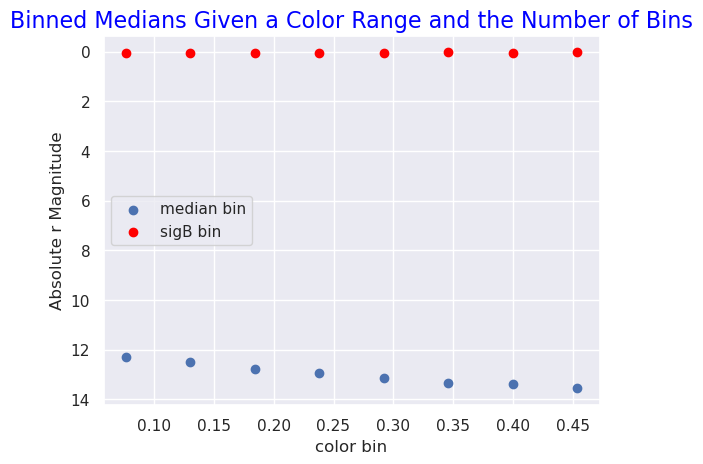

In [80]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['ug'], df_DC['r_MagAbs'], 
                                        xMin=0.05, xMax=0.48, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 2.766229109316447 6.925112192676119
 best quadratic model: 0.692616131309953 6.93094075634946
     best cubic model: 0.6697249314825727 8.987491098201916
best 4-th order model: 0.49031381795877327 10.887521526357952
best 5-th order model: 0.49158390367575866 12.968233153754772
best 6-th order model: 0.4914419897466407 15.04753278150549


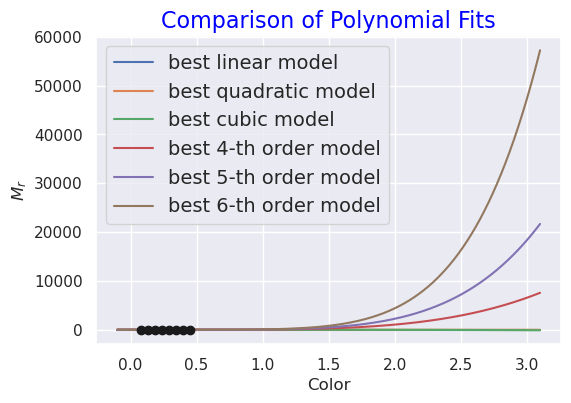

In [81]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 3.3728, 12.0997 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

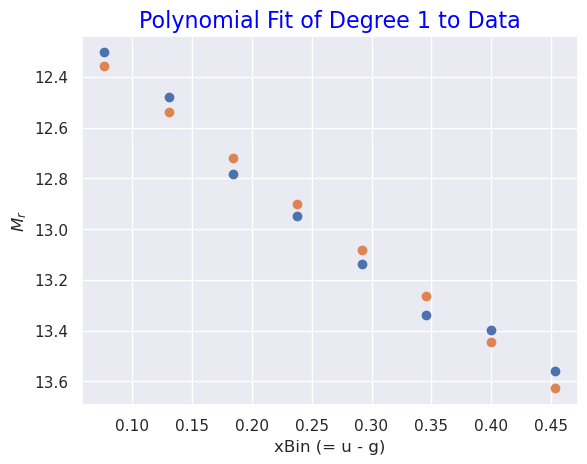

In [82]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= u - g)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


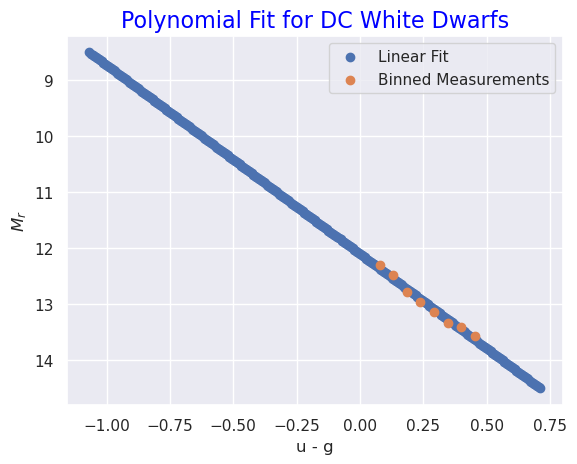

In [83]:

# list of coefficients in descending order of powers
DCug_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DCug_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DCug_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('u - g')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

#### <span style='color:green'>III.3b DC for g - r

In [84]:
xMin = np.min(df_DC['gr'])
xMax = np.max(df_DC['gr'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.598, 0.486


xBins   medianBin   SigmaGBin     # Pts.  
-0.196      12.19        0.04          45
-0.147      12.38        0.03          65
-0.098      12.69        0.04          70
-0.049      12.84        0.04          53
-0.001      13.15        0.05          55
0.048      13.31        0.02          67
0.097      13.45        0.04          58
0.146      13.63        0.04          38


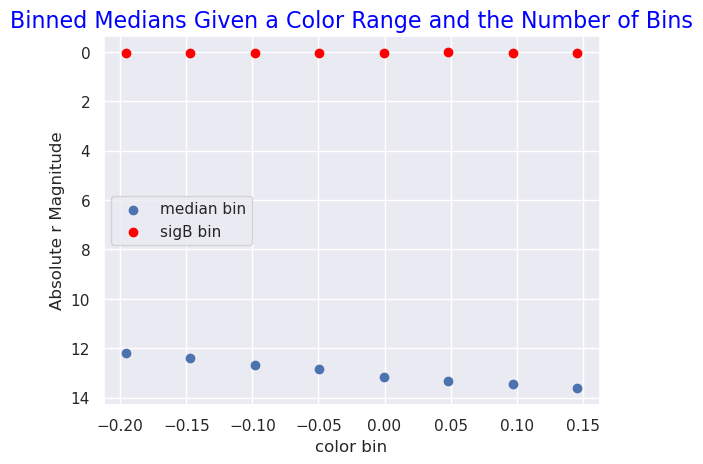

In [85]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['gr'], df_DC['r_MagAbs'], 
                                        xMin=-0.22, xMax=0.17, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 2.2228890641229815 6.381772147482653
 best quadratic model: 0.8946166851302755 7.132941310169782
     best cubic model: 0.8003963517713175 9.11816251849066
best 4-th order model: 0.6733541140784988 11.070561822477679
best 5-th order model: 0.6741300729285618 13.150779323007576
best 6-th order model: 0.6468305784859405 15.202921370244791


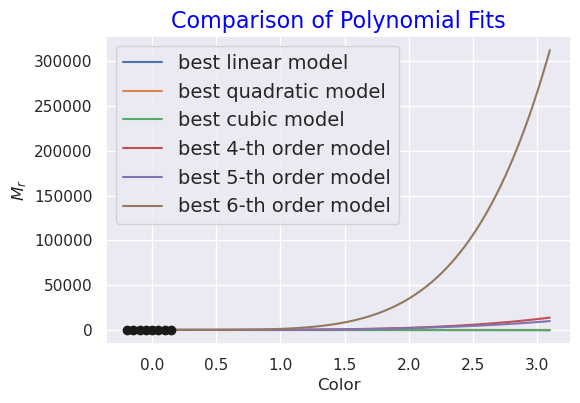

In [86]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 4.2966, 13.0632 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

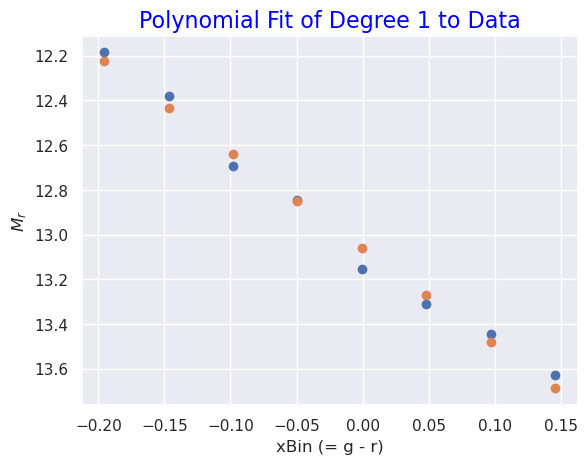

In [87]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= g - r)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


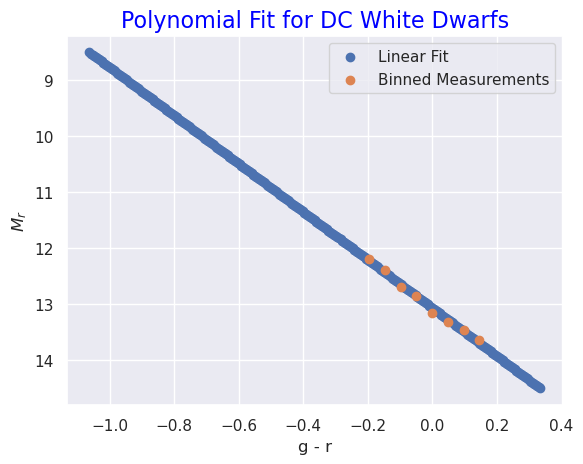

In [88]:
# list of coefficients in descending order of powers
DCgr_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DCgr_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DCgr_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('g - r')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()


#### <span style='color:green'> III.3c DC for r - i

In [89]:
xMin = np.min(df_DC['ri'])
xMax = np.max(df_DC['ri'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.489, 0.272


xBins   medianBin   SigmaGBin     # Pts.  
-0.186      12.27        0.03          53
-0.159      12.48        0.04          67
-0.131      12.76        0.04          56
-0.104      12.97        0.05          51
-0.076      13.18        0.04          61
-0.049      13.38        0.03          52
-0.021      13.47        0.05          50
0.006      13.61        0.04          47


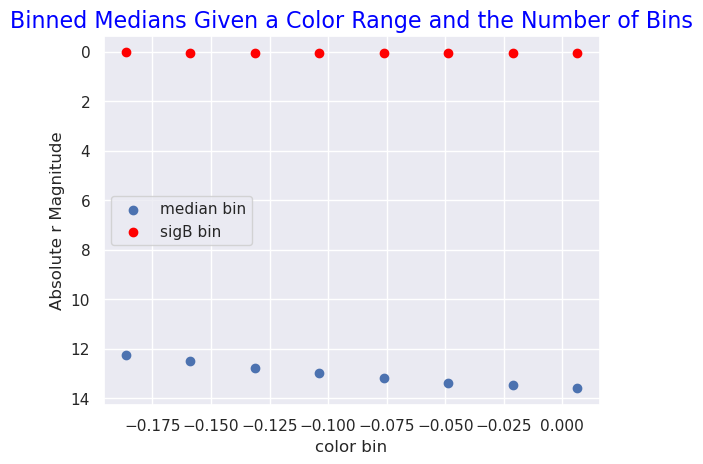

In [90]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['ri'], df_DC['r_MagAbs'], 
                                        xMin=-0.2, xMax=0.02, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 3.1101051863135156 7.268988269673187
 best quadratic model: 0.37093753793540385 6.609262162974911
     best cubic model: 0.27041932433121996 8.588185491050563
best 4-th order model: 0.18164185739941152 10.57884956579859
best 5-th order model: 0.18240143361879374 12.659050683697807
best 6-th order model: 0.18247018241151927 14.738560974170369


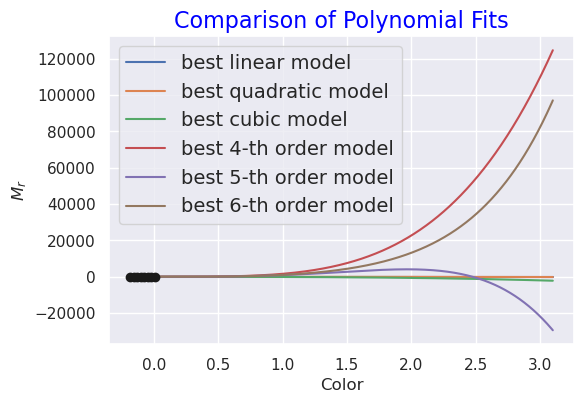

In [91]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are -16.8845, 4.0558, 13.5832 


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

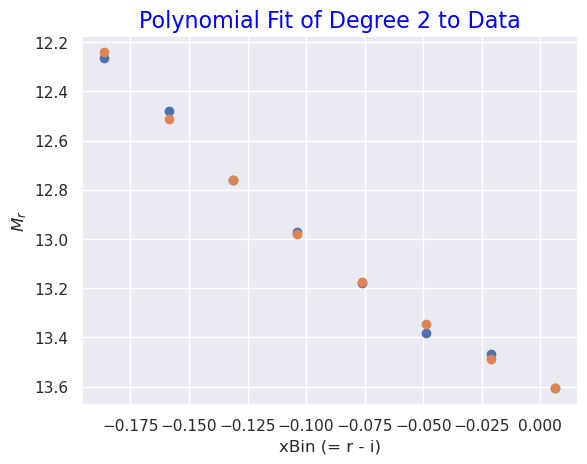

In [92]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f ' %(z[0], z[1], z[2]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= r - i)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


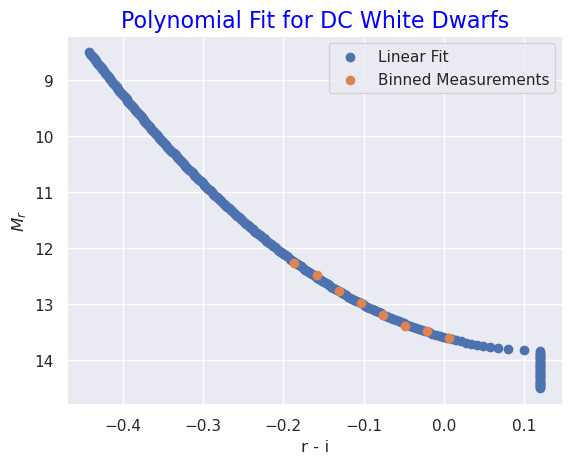

In [93]:
# list of coefficients in descending order of powers
DCri_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DCri_roots.append(np.roots(z2)[1])
#     print(np.roots(z2)[0])

plt.scatter(DCri_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('r - i')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

#### <span style='color:green'> III.3d DC for i - z

In [94]:
xMin = np.min(df_DC['iz'])
xMax = np.max(df_DC['iz'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -1.446, 0.110


xBins   medianBin   SigmaGBin     # Pts.  
-0.210      12.44        0.07          37
-0.190      12.68        0.09          58
-0.170      12.96        0.07          53
-0.150      12.79        0.09          43
-0.130      13.18        0.07          44
-0.110      13.26        0.06          48
-0.090      13.58        0.08          43
-0.070      13.64        0.06          28


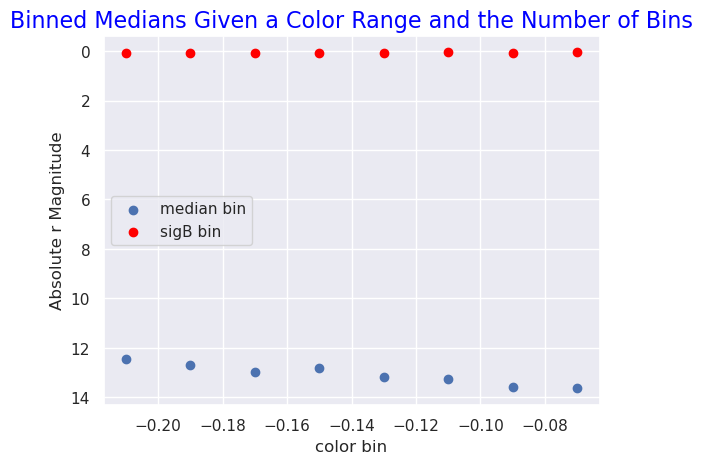

In [95]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['iz'], df_DC['r_MagAbs'], 
                                        xMin=-0.22, xMax=-0.06, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 7.293828913357436 11.452711996717108
 best quadratic model: 7.256220981663791 13.494545606703298
     best cubic model: 7.130421298658385 15.448187465377728
best 4-th order model: 4.86630628116652 15.263513989565698
best 5-th order model: 4.88073764170628 17.357386891785293
best 6-th order model: 4.884321134269972 19.440411926028823


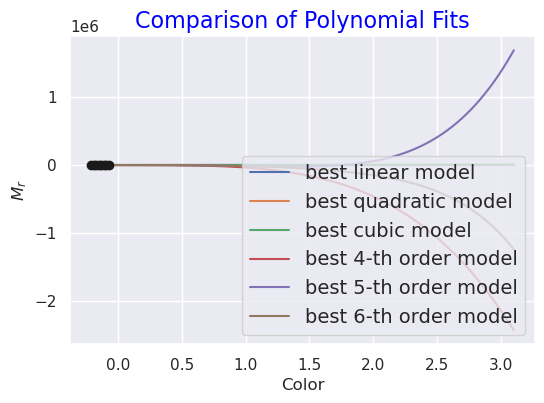

In [96]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 8.4598, 14.2495 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

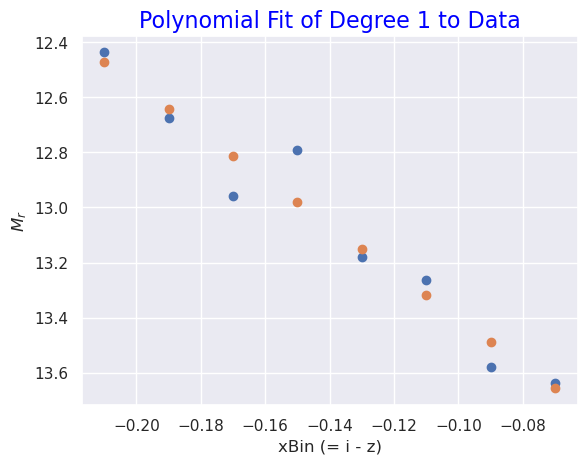

In [97]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= i - z)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')



('fontsize=16,', "color='blue'")

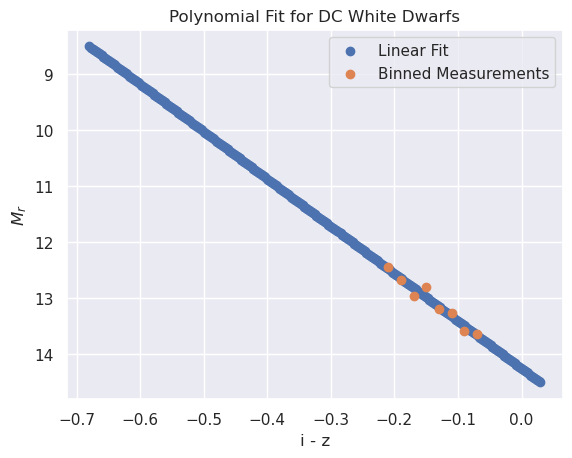

In [98]:
# list of coefficients in descending order of powers
DCiz_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DCiz_roots.append(np.roots(z2))
    
plt.scatter(DCiz_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('i - z')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
, fontsize=16, color='blue'

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Color Magnitude Fits for DC White Dwarfs')

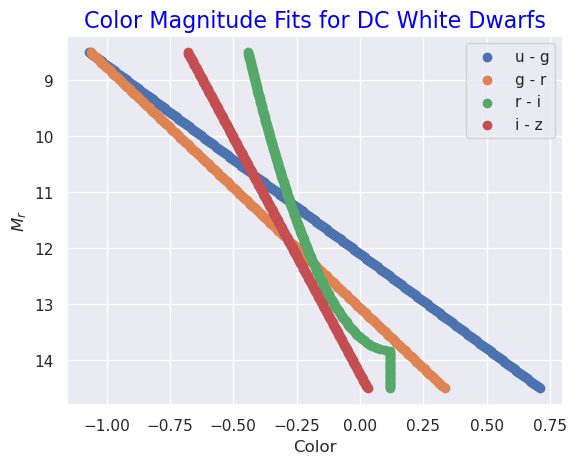

In [99]:
plt.scatter(DCug_roots, Mr, label='u - g')
plt.scatter(DCgr_roots, Mr, label='g - r')
plt.scatter(DCri_roots, Mr, label='r - i')
plt.scatter(DCiz_roots, Mr, label='i - z')
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('$M_{r}$')
plt.legend()
plt.title('Color Magnitude Fits for DC White Dwarfs', fontsize=16, color='blue')